## Block 1: Import Libraries

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
! pip install kaggle

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadqasimshabbir/slideandseekclasificationlandslidedetectiondataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/slideandseekclasificationlandslidedetectiondataset


[link text](https://)## Block 2: Define Paths and Load CSV Files

In [5]:
# Define paths for the dataset (remember to unzip the dataset first!)
train_csv_path = path+'/Train.csv'
test_csv_path = path+'/Test.csv'    # Path to the test image IDs CSV file
train_data_path = path+'/train_data/train_data'  # Folder where .npy train files are located
test_data_path = path+'/test_data/test_data'    # Folder where .npy test files are located

train_df = pd.read_csv(train_csv_path)
print("Train.csv:")
print(train_df)

Train.csv:
             ID  label
0     ID_HUD1ST      1
1     ID_KGE2HY      1
2     ID_VHV9BL      1
3     ID_ZT0VEJ      0
4     ID_5NFXVY      0
...         ...    ...
7142  ID_7RINJF      1
7143  ID_UAYBOC      0
7144  ID_M0YJD0      0
7145  ID_PI0GHW      0
7146  ID_VNBDTG      0

[7147 rows x 2 columns]


In [6]:
train_df.label.value_counts()

,count
label,
0,5892
1,1255


## Block 3: Visualize Label Distribution

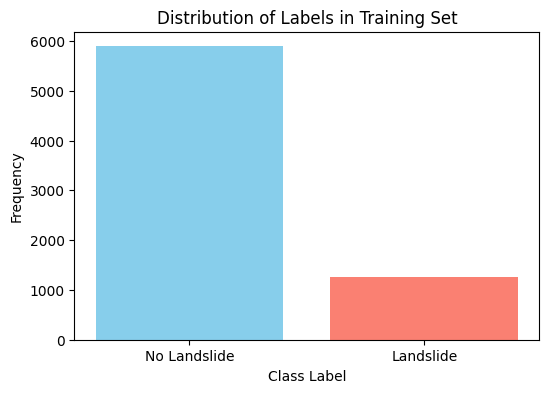

In [7]:
# Check distribution of labels
label_counts = train_df['label'].value_counts()
labels = ['No Landslide', 'Landslide']  # Map the labels 0 and 1 to descriptive names

plt.figure(figsize=(6, 4))
plt.bar(labels, label_counts.values, color=['skyblue', 'salmon'])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.show()

## Block 4: Load, Normalize, and Display Sample Multi-band Images

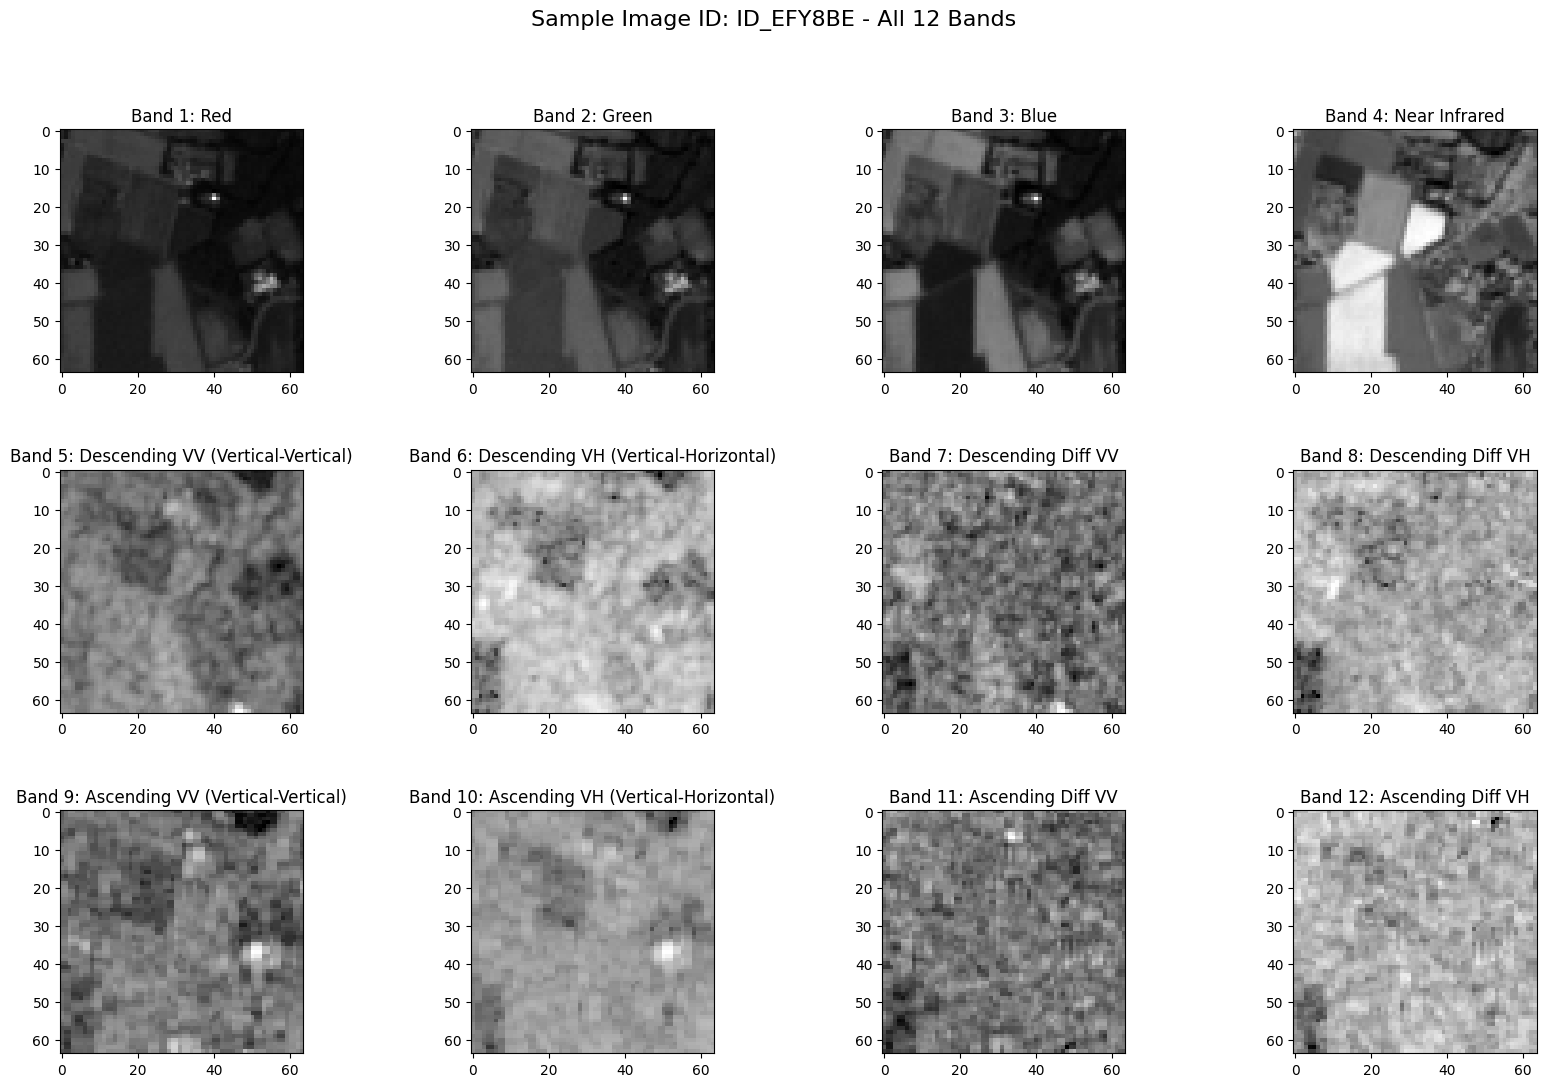

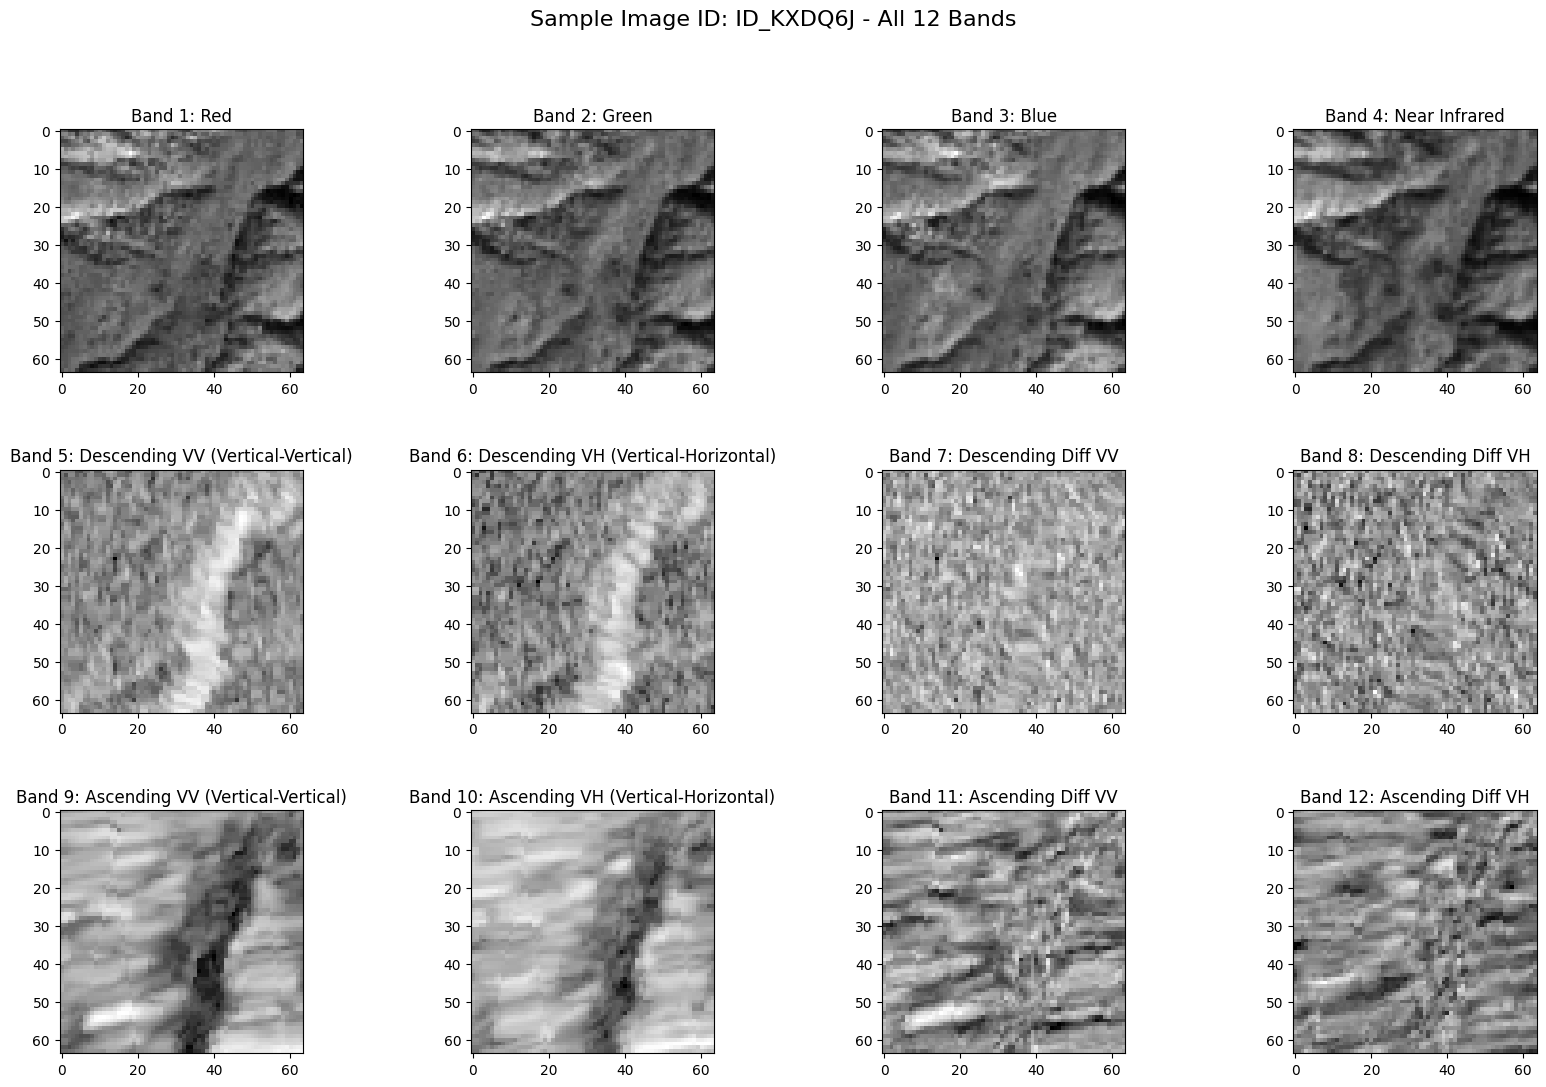

In [8]:
# Function to load and normalize .npy images
def load_and_normalize_npy_image(image_id, folder_path):
    """Loads a .npy file, normalizes each band, and returns the normalized image."""
    image_path = os.path.join(folder_path, f"{image_id}.npy")
    img = np.load(image_path)

    # Normalize each band to the 0-1 range
    img_normalized = (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1)) + 1e-5)
    return img_normalized

# Band descriptions
band_descriptions = [
    "Red", "Green", "Blue", "Near Infrared",
    "Descending VV (Vertical-Vertical)", "Descending VH (Vertical-Horizontal)",
    "Descending Diff VV", "Descending Diff VH",
    "Ascending VV (Vertical-Vertical)", "Ascending VH (Vertical-Horizontal)",
    "Ascending Diff VV", "Ascending Diff VH"
]

# Displaying a few example images with all 12 bands
example_ids = train_df['ID'].sample(2).values  # Randomly select 2 image IDs for illustration

for image_id in example_ids:
    img_normalized = load_and_normalize_npy_image(image_id, train_data_path)

    # Plot all 12 bands in a 3x4 grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns for 12 plots
    fig.suptitle(f"Sample Image ID: {image_id} - All 12 Bands", fontsize=16)

    # Display each of the 12 bands with descriptions
    for band in range(12):
        row = band // 4  # Calculate row index (0, 1, or 2)
        col = band % 4   # Calculate column index (0 to 3)
        axes[row, col].imshow(img_normalized[:, :, band], cmap='gray')
        axes[row, col].set_title(f"Band {band + 1}: {band_descriptions[band]}")


    plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust spacing between plots
    plt.show()

## Block 5: Prepare Data for Model Training

In [9]:
import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class NpyImageGenerator(Sequence):
    """Custom generator for loading .npy images batch by batch"""

    def __init__(self, image_ids, labels, folder_path, batch_size=32,
                 augment=False, shuffle=True, seed=42):
        self.image_ids = image_ids
        self.labels = labels
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed

        # Set up augmentation
        if augment:
            self.datagen = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = None

        # Initialize indices
        self.indices = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(self.indices)

    def __len__(self):
        """Number of batches per epoch"""
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Get batch indices
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.image_ids))
        batch_indices = self.indices[start_idx:end_idx]

        # Get batch data
        batch_ids = [self.image_ids[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        # Load and process images
        batch_images = []
        for image_id in batch_ids:
            img = self.load_and_normalize_npy_image(image_id)
            batch_images.append(img)

        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        # Apply augmentation if specified
        if self.datagen is not None:
            # Apply augmentation to each image in the batch
            augmented_images = []
            for i in range(len(batch_images)):
                # Reshape for ImageDataGenerator (expects 4D: batch, height, width, channels)
                img_batch = np.expand_dims(batch_images[i], axis=0)
                augmented = next(self.datagen.flow(img_batch, batch_size=1, shuffle=False))
                augmented_images.append(augmented[0])
            batch_images = np.array(augmented_images)

        return batch_images, batch_labels

    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_and_normalize_npy_image(self, image_id):
        """Load and normalize a single .npy image"""
        image_path = os.path.join(self.folder_path, f"{image_id}.npy")
        img = np.load(image_path)
        # Normalize each band to the 0-1 range
        img_normalized = (img - img.min(axis=(0, 1))) / (img.max(axis=(0, 1)) - img.min(axis=(0, 1)) + 1e-5)
        return img_normalized

In [10]:
folder_path = train_data_path
folder_path

'/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data'

In [11]:
image_ids = train_df['ID'].values
labels = train_df['label'].values
image_ids.shape

(7147,)

Stratified split

In [12]:
from sklearn.model_selection import train_test_split
train_ids, val_ids, train_labels, val_labels = train_test_split(
    image_ids, labels, test_size=0.2, random_state=42, stratify=labels)

# Create custom generators


In [13]:
batch_size = 32

train_generator = NpyImageGenerator(
    image_ids=train_ids,
    labels=train_labels,
    folder_path=folder_path,
    batch_size=batch_size,
    augment=True,  # Apply augmentation to training data
    shuffle=True,
    seed=42
)

val_generator = NpyImageGenerator(
    image_ids=val_ids,
    labels=val_labels,
    folder_path=folder_path,
    batch_size=batch_size,
    augment=False,  # No augmentation for validation
    shuffle=False,
    seed=42
)


In [14]:
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(val_generator)}")


Number of training batches: 179
Number of validation batches: 45


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ConvNeXtSmall
# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define the Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed


# Input layer for 12-channel images
inputs = keras.Input(shape=(64, 64, 12))

# First channel reduction layer: 12 -> 6 channels
x = layers.Conv2D(3, (3,3), padding='same', use_bias=False, name='channel_conv1')(inputs)
x = layers.BatchNormalization(name='channel_bn1')(x)
x = layers.Activation('relu', name='channel_gelu1')(x)


# Load pretrained ConvNeXt Large base (without top classifier and preprocessing)
convnext_base = ConvNeXtSmall(
    weights='imagenet',
    include_top=False,
    include_preprocessing=False,  # This is key - disable preprocessing
    input_shape=(64, 64, 3),     # Specify 3-channel input shape
    pooling='avg'
)
for layer in convnext_base.layers:
    layer.trainable=False
# Apply ConvNeXt to our processed tensor
features = convnext_base(x)

# Binary classification head
outputs = layers.Dense(1, activation='sigmoid', name='predictions')(features)

# Create the complete model
model = keras.Model(inputs, outputs, name='convnext_12channel_classifier')

# Compile the model
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

# Print model summary
print(model.summary())

# Test with dummy data
dummy_input = tf.random.normal((1, 64, 64, 12))
output = model(dummy_input)
print(f"Output shape: {output.shape}")
print(f"Sample prediction: {output.numpy()}")

# Optional: Visualize model architecture
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

KeyboardInterrupt: 

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ConvNeXtSmall
# Precision metric
def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall metric
def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32 to match y_pred type
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


# F1 Score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define the Focal Loss function
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for binary classification.

    Parameters:
        gamma (float): Focusing parameter; typically set to 2.0.
        alpha (float): Balancing factor; typically set to 0.25.

    Returns:
        Binary Focal Loss function.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)

        # Calculate focal loss
        fl = -alpha * K.pow(1 - p_t, gamma) * K.log(p_t)
        return K.mean(fl)

    return focal_loss_fixed

# Input layer for 12-channel images
inputs = keras.Input(shape=(64, 64, 12))



model = keras.Sequential([
        # Input layer for 12-channel images
        keras.Input(shape=(64, 64, 12)),

        # Channel reduction layer: 12 -> 3 channels
        layers.Conv2D(3, (3, 3), padding='same', use_bias=False, name='channel_conv1'),
        layers.BatchNormalization(name='channel_bn1'),
        layers.Activation('LeakyReLU', name='channel_relu1'),

        # Pretrained ConvNeXt Small (will be added separately)
    ])

    # Load pretrained model
pretrained_model = ConvNeXtSmall(
      weights='imagenet',
      include_top=False,
      include_preprocessing=False,
      input_shape=(64, 64, 3),
      pooling='avg'
  )

# Freeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add pretrained model and classification layers
model.add(pretrained_model)
model.add(layers.Dense(128, activation='relu', name='dense_128'))
model.add(layers.Dropout(0.5, name='dropout'))  # Optional
model.add(layers.Dense(1, activation='sigmoid', name='classification_output'))



# Compile the model
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy', precision_m, recall_m, f1_m]
)

# Print model summary
print(model.summary())

# Test with dummy data
dummy_input = tf.random.normal((1, 64, 64, 12))
output = model(dummy_input)
print(f"Output shape: {output.shape}")
print(f"Sample prediction: {output.numpy()}")

# Optional: Visualize model architecture
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ channel_conv1 (Conv2D)          │ (None, 64, 64, 3)      │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_bn1                     │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ channel_relu1 (Activation)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 768)            │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,553,585 (189.03 MB)

 Trainable params: 98,891 (386.29 KB)

 Non-trainable params: 49,454,694 (188.65 MB)

None
Output shape: (1, 1)
Sample prediction: [[0.30020446]]


## Block 7: Train the Model

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a checkpoint callback that saves the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath="best_model_savedmodel.keras",            # Filepath to save the model with .keras extension

    monitor='val_f1_m',         # Monitor the validation loss
    verbose=1,                  # Verbos ity mode; 1 prints messages when a new best is found
    save_best_only=True,        # Save only the model with the best performance
    mode='max'                  # Change mode to 'max' for f1_m (higher is better)
)
history = model.fit(
    train_generator,     # Use custom generator instead of train_ds
    epochs=15,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step - accuracy: 0.7934 - f1_m: 3.7474 - loss: 0.1440 - precision_m: 4.7778 - recall_m: 3.6111

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  4/179 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.7806 - f1_m: 3.8861 - loss: 0.1416 - precision_m: 4.6458 - recall_m: 3.9583

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  7/179 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.7675 - f1_m: 4.0594 - loss: 0.1332 - precision_m: 4.5031 - recall_m: 4.3197

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 10/179 ━━━━━━━━━━━━━━━━━━━━ 46s 274ms/step - accuracy: 0.7601 - f1_m: 4.1158 - loss: 0.1388 - precision_m: 4.7816 - recall_m: 4.2999

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 16/179 ━━━━━━━━━━━━━━━━━━━━ 46s 283ms/step - accuracy: 0.7479 - f1_m: 4.5525 - loss: 0.1451 - precision_m: 5.1727 - recall_m: 4.9371

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 17/179 ━━━━━━━━━━━━━━━━━━━━ 46s 287ms/step - accuracy: 0.7464 - f1_m: 4.6116 - loss: 0.1453 - precision_m: 5.2110 - recall_m: 5.0273

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 19/179 ━━━━━━━━━━━━━━━━━━━━ 46s 289ms/step - accuracy: 0.7441 - f1_m: 4.7144 - loss: 0.1453 - precision_m: 5.2798 - recall_m: 5.1725

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 23/179 ━━━━━━━━━━━━━━━━━━━━ 1:50 709ms/step - accuracy: 0.7428 - f1_m: 4.8137 - loss: 0.1440 - precision_m: 5.3483 - recall_m: 5.3034

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 25/179 ━━━━━━━━━━━━━━━━━━━━ 1:43 675ms/step - accuracy: 0.7428 - f1_m: 4.8391 - loss: 0.1432 - precision_m: 5.3760 - recall_m: 5.3282

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 29/179 ━━━━━━━━━━━━━━━━━━━━ 1:33 620ms/step - accuracy: 0.7434 - f1_m: 4.8675 - loss: 0.1412 - precision_m: 5.4167 - recall_m: 5.3384

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 32/179 ━━━━━━━━━━━━━━━━━━━━ 1:26 589ms/step - accuracy: 0.7443 - f1_m: 4.8823 - loss: 0.1395 - precision_m: 5.4512 - recall_m: 5.3340

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 36/179 ━━━━━━━━━━━━━━━━━━━━ 1:19 555ms/step - accuracy: 0.7458 - f1_m: 4.8955 - loss: 0.1369 - precision_m: 5.4832 - recall_m: 5.3371

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 39/179 ━━━━━━━━━━━━━━━━━━━━ 1:14 534ms/step - accuracy: 0.7465 - f1_m: 4.9090 - loss: 0.1351 - precision_m: 5.5047 - recall_m: 5.3463

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 43/179 ━━━━━━━━━━━━━━━━━━━━ 1:09 510ms/step - accuracy: 0.7470 - f1_m: 4.9191 - loss: 0.1327 - precision_m: 5.5273 - recall_m: 5.3444

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 47/179 ━━━━━━━━━━━━━━━━━━━━ 1:06 503ms/step - accuracy: 0.7475 - f1_m: 4.9181 - loss: 0.1304 - precision_m: 5.5377 - recall_m: 5.3279

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 48/179 ━━━━━━━━━━━━━━━━━━━━ 1:05 502ms/step - accuracy: 0.7477 - f1_m: 4.9160 - loss: 0.1299 - precision_m: 5.5404 - recall_m: 5.3210

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 54/179 ━━━━━━━━━━━━━━━━━━━━ 59s 478ms/step - accuracy: 0.7483 - f1_m: 4.9110 - loss: 0.1270 - precision_m: 5.5619 - recall_m: 5.2854 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 58/179 ━━━━━━━━━━━━━━━━━━━━ 56s 466ms/step - accuracy: 0.7486 - f1_m: 4.9082 - loss: 0.1252 - precision_m: 5.5729 - recall_m: 5.2642

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 61/179 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - accuracy: 0.7487 - f1_m: 4.9078 - loss: 0.1239 - precision_m: 5.5846 - recall_m: 5.2498

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 65/179 ━━━━━━━━━━━━━━━━━━━━ 50s 447ms/step - accuracy: 0.7491 - f1_m: 4.9082 - loss: 0.1223 - precision_m: 5.5952 - recall_m: 5.2356

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 68/179 ━━━━━━━━━━━━━━━━━━━━ 48s 441ms/step - accuracy: 0.7494 - f1_m: 4.9053 - loss: 0.1211 - precision_m: 5.5977 - recall_m: 5.2231

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 71/179 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - accuracy: 0.7497 - f1_m: 4.9004 - loss: 0.1200 - precision_m: 5.6042 - recall_m: 5.2072

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 74/179 ━━━━━━━━━━━━━━━━━━━━ 45s 429ms/step - accuracy: 0.7500 - f1_m: 4.8929 - loss: 0.1190 - precision_m: 5.6117 - recall_m: 5.1879

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 80/179 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.7507 - f1_m: 4.8763 - loss: 0.1169 - precision_m: 5.6249 - recall_m: 5.1495

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 81/179 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.7508 - f1_m: 4.8737 - loss: 0.1166 - precision_m: 5.6275 - recall_m: 5.1432

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 85/179 ━━━━━━━━━━━━━━━━━━━━ 39s 418ms/step - accuracy: 0.7513 - f1_m: 4.8607 - loss: 0.1154 - precision_m: 5.6355 - recall_m: 5.1155

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 87/179 ━━━━━━━━━━━━━━━━━━━━ 38s 417ms/step - accuracy: 0.7515 - f1_m: 4.8546 - loss: 0.1148 - precision_m: 5.6393 - recall_m: 5.1021

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 89/179 ━━━━━━━━━━━━━━━━━━━━ 37s 415ms/step - accuracy: 0.7518 - f1_m: 4.8478 - loss: 0.1142 - precision_m: 5.6426 - recall_m: 5.0880

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 95/179 ━━━━━━━━━━━━━━━━━━━━ 34s 407ms/step - accuracy: 0.7526 - f1_m: 4.8261 - loss: 0.1125 - precision_m: 5.6476 - recall_m: 5.0454

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 96/179 ━━━━━━━━━━━━━━━━━━━━ 33s 406ms/step - accuracy: 0.7527 - f1_m: 4.8223 - loss: 0.1122 - precision_m: 5.6480 - recall_m: 5.0382

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 99/179 ━━━━━━━━━━━━━━━━━━━━ 32s 403ms/step - accuracy: 0.7531 - f1_m: 4.8102 - loss: 0.1114 - precision_m: 5.6489 - recall_m: 5.0161

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


102/179 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step - accuracy: 0.7535 - f1_m: 4.7975 - loss: 0.1107 - precision_m: 5.6485 - recall_m: 4.9936

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


105/179 ━━━━━━━━━━━━━━━━━━━━ 29s 397ms/step - accuracy: 0.7539 - f1_m: 4.7837 - loss: 0.1099 - precision_m: 5.6477 - recall_m: 4.9701

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


108/179 ━━━━━━━━━━━━━━━━━━━━ 28s 394ms/step - accuracy: 0.7544 - f1_m: 4.7683 - loss: 0.1092 - precision_m: 5.6445 - recall_m: 4.9452

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


112/179 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.7551 - f1_m: 4.7444 - loss: 0.1082 - precision_m: 5.6347 - recall_m: 4.9096

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.7557 - f1_m: 4.7248 - loss: 0.1075 - precision_m: 5.6254 - recall_m: 4.8817

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


118/179 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.7562 - f1_m: 4.7039 - loss: 0.1068 - precision_m: 5.6140 - recall_m: 4.8529

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


121/179 ━━━━━━━━━━━━━━━━━━━━ 22s 385ms/step - accuracy: 0.7568 - f1_m: 4.6831 - loss: 0.1062 - precision_m: 5.6027 - recall_m: 4.8242

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


124/179 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - accuracy: 0.7573 - f1_m: 4.6627 - loss: 0.1055 - precision_m: 5.5922 - recall_m: 4.7960

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


126/179 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.7576 - f1_m: 4.6494 - loss: 0.1051 - precision_m: 5.5852 - recall_m: 4.7776

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


132/179 ━━━━━━━━━━━━━━━━━━━━ 18s 384ms/step - accuracy: 0.7586 - f1_m: 4.6081 - loss: 0.1039 - precision_m: 5.5619 - recall_m: 4.7218

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


133/179 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - accuracy: 0.7588 - f1_m: 4.6012 - loss: 0.1037 - precision_m: 5.5583 - recall_m: 4.7125

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


136/179 ━━━━━━━━━━━━━━━━━━━━ 16s 382ms/step - accuracy: 0.7593 - f1_m: 4.5809 - loss: 0.1032 - precision_m: 5.5476 - recall_m: 4.6851

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


142/179 ━━━━━━━━━━━━━━━━━━━━ 13s 378ms/step - accuracy: 0.7603 - f1_m: 4.5401 - loss: 0.1020 - precision_m: 5.5259 - recall_m: 4.6310

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


143/179 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - accuracy: 0.7605 - f1_m: 4.5333 - loss: 0.1019 - precision_m: 5.5225 - recall_m: 4.6220

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


146/179 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step - accuracy: 0.7610 - f1_m: 4.5132 - loss: 0.1013 - precision_m: 5.5119 - recall_m: 4.5953

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


152/179 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.7620 - f1_m: 4.4733 - loss: 0.1003 - precision_m: 5.4913 - recall_m: 4.5428

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


153/179 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.7622 - f1_m: 4.4666 - loss: 0.1001 - precision_m: 5.4877 - recall_m: 4.5340 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


156/179 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.7627 - f1_m: 4.4467 - loss: 0.0996 - precision_m: 5.4774 - recall_m: 4.5080

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


160/179 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.7633 - f1_m: 4.4203 - loss: 0.0990 - precision_m: 5.4632 - recall_m: 4.4738

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


164/179 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.7640 - f1_m: 4.3946 - loss: 0.0984 - precision_m: 5.4498 - recall_m: 4.4403

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


165/179 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.7641 - f1_m: 4.3883 - loss: 0.0983 - precision_m: 5.4469 - recall_m: 4.4321

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


170/179 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7649 - f1_m: 4.3577 - loss: 0.0975 - precision_m: 5.4333 - recall_m: 4.3918

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


172/179 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7652 - f1_m: 4.3458 - loss: 0.0972 - precision_m: 5.4283 - recall_m: 4.3760

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


175/179 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step - accuracy: 0.7656 - f1_m: 4.3281 - loss: 0.0968 - precision_m: 5.4209 - recall_m: 4.3527

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7660 - f1_m: 4.3108 - loss: 0.0964 - precision_m: 5.4139 - recall_m: 4.3299

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7661 - f1_m: 4.3052 - loss: 0.0963 - precision_m: 5.4117 - recall_m: 4.3224
Epoch 1: val_f1_m improved from -inf to 0.49922, saving model to best_model_savedmodel.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 113s 467ms/step - accuracy: 0.7663 - f1_m: 4.2996 - loss: 0.0962 - precision_m: 5.4095 - recall_m: 4.3151 - val_accuracy: 0.8217 - val_f1_m: 0.4992 - val_loss: 0.0501 - val_precision_m: 1.5111 - val_recall_m: 0.3111
Epoch 2/15


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 1:01 352ms/step - accuracy: 0.8385 - f1_m: 2.2278 - loss: 0.0723 - precision_m: 4.6667 - recall_m: 1.5000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  7/179 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.8235 - f1_m: 2.4690 - loss: 0.0679 - precision_m: 5.0078 - recall_m: 1.7534

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  8/179 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.8231 - f1_m: 2.4308 - loss: 0.0673 - precision_m: 4.8818 - recall_m: 1.7374

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 13/179 ━━━━━━━━━━━━━━━━━━━━ 39s 238ms/step - accuracy: 0.8214 - f1_m: 2.3141 - loss: 0.0648 - precision_m: 4.4608 - recall_m: 1.6811

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 19/179 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - accuracy: 0.8213 - f1_m: 2.2128 - loss: 0.0630 - precision_m: 4.1786 - recall_m: 1.6136

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 23/179 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - accuracy: 0.8218 - f1_m: 2.1295 - loss: 0.0621 - precision_m: 4.0252 - recall_m: 1.5511

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 27/179 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.8209 - f1_m: 2.0727 - loss: 0.0615 - precision_m: 3.9367 - recall_m: 1.5058

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 31/179 ━━━━━━━━━━━━━━━━━━━━ 32s 221ms/step - accuracy: 0.8205 - f1_m: 2.0252 - loss: 0.0610 - precision_m: 3.8789 - recall_m: 1.4668

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 36/179 ━━━━━━━━━━━━━━━━━━━━ 31s 218ms/step - accuracy: 0.8204 - f1_m: 1.9922 - loss: 0.0604 - precision_m: 3.8736 - recall_m: 1.4361

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 40/179 ━━━━━━━━━━━━━━━━━━━━ 30s 217ms/step - accuracy: 0.8201 - f1_m: 1.9832 - loss: 0.0600 - precision_m: 3.8858 - recall_m: 1.4262

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 45/179 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - accuracy: 0.8197 - f1_m: 1.9836 - loss: 0.0596 - precision_m: 3.8967 - recall_m: 1.4257

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 50/179 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.8197 - f1_m: 1.9901 - loss: 0.0592 - precision_m: 3.9081 - recall_m: 1.4307

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 54/179 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.8197 - f1_m: 1.9914 - loss: 0.0589 - precision_m: 3.9166 - recall_m: 1.4309

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 57/179 ━━━━━━━━━━━━━━━━━━━━ 27s 228ms/step - accuracy: 0.8197 - f1_m: 1.9896 - loss: 0.0586 - precision_m: 3.9228 - recall_m: 1.4286

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 62/179 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - accuracy: 0.8197 - f1_m: 1.9795 - loss: 0.0583 - precision_m: 3.9229 - recall_m: 1.4196

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 66/179 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.8195 - f1_m: 1.9692 - loss: 0.0581 - precision_m: 3.9206 - recall_m: 1.4106

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 74/179 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.8193 - f1_m: 1.9429 - loss: 0.0578 - precision_m: 3.8981 - recall_m: 1.3893

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 76/179 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.8192 - f1_m: 1.9370 - loss: 0.0577 - precision_m: 3.8940 - recall_m: 1.3846

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 81/179 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.8191 - f1_m: 1.9256 - loss: 0.0575 - precision_m: 3.8892 - recall_m: 1.3761

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 89/179 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.8188 - f1_m: 1.9089 - loss: 0.0572 - precision_m: 3.8841 - recall_m: 1.3634

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 91/179 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.8187 - f1_m: 1.9042 - loss: 0.0572 - precision_m: 3.8811 - recall_m: 1.3599

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 99/179 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.8186 - f1_m: 1.8813 - loss: 0.0570 - precision_m: 3.8581 - recall_m: 1.3428

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


103/179 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.8185 - f1_m: 1.8688 - loss: 0.0569 - precision_m: 3.8430 - recall_m: 1.3334

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


105/179 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.8186 - f1_m: 1.8621 - loss: 0.0568 - precision_m: 3.8341 - recall_m: 1.3284

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


108/179 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step - accuracy: 0.8186 - f1_m: 1.8523 - loss: 0.0567 - precision_m: 3.8214 - recall_m: 1.3211

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


113/179 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.8187 - f1_m: 1.8366 - loss: 0.0566 - precision_m: 3.8023 - recall_m: 1.3092

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - accuracy: 0.8187 - f1_m: 1.8300 - loss: 0.0566 - precision_m: 3.7934 - recall_m: 1.3042

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


120/179 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.8189 - f1_m: 1.8130 - loss: 0.0565 - precision_m: 3.7704 - recall_m: 1.2914

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


128/179 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.8190 - f1_m: 1.7866 - loss: 0.0564 - precision_m: 3.7381 - recall_m: 1.2713

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


129/179 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.8190 - f1_m: 1.7833 - loss: 0.0564 - precision_m: 3.7337 - recall_m: 1.2688

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


134/179 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.8190 - f1_m: 1.7675 - loss: 0.0563 - precision_m: 3.7142 - recall_m: 1.2567

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


143/179 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8191 - f1_m: 1.7421 - loss: 0.0562 - precision_m: 3.6852 - recall_m: 1.2372

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


144/179 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.8191 - f1_m: 1.7394 - loss: 0.0562 - precision_m: 3.6824 - recall_m: 1.2351

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


149/179 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8191 - f1_m: 1.7262 - loss: 0.0561 - precision_m: 3.6685 - recall_m: 1.2248

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


153/179 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8191 - f1_m: 1.7161 - loss: 0.0561 - precision_m: 3.6589 - recall_m: 1.2169

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


158/179 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8190 - f1_m: 1.7035 - loss: 0.0560 - precision_m: 3.6455 - recall_m: 1.2071

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


163/179 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.8189 - f1_m: 1.6923 - loss: 0.0560 - precision_m: 3.6321 - recall_m: 1.1990

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


166/179 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.8189 - f1_m: 1.6857 - loss: 0.0560 - precision_m: 3.6234 - recall_m: 1.1941

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


173/179 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.8189 - f1_m: 1.6705 - loss: 0.0559 - precision_m: 3.6025 - recall_m: 1.1831

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


174/179 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.8189 - f1_m: 1.6683 - loss: 0.0559 - precision_m: 3.5994 - recall_m: 1.1816

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8189 - f1_m: 1.6577 - loss: 0.0558 - precision_m: 3.5847 - recall_m: 1.1738

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(



Epoch 2: val_f1_m did not improve from 0.49922
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.8189 - f1_m: 1.6556 - loss: 0.0558 - precision_m: 3.5818 - recall_m: 1.1723 - val_accuracy: 0.8224 - val_f1_m: 0.3179 - val_loss: 0.0502 - val_precision_m: 0.8222 - val_recall_m: 0.2000
Epoch 3/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 47s 265ms/step - accuracy: 0.8750 - f1_m: 0.0000e+00 - loss: 0.0482 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - accuracy: 0.8264 - f1_m: 0.0000e+00 - loss: 0.0498 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 13/179 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.8204 - f1_m: 0.5347 - loss: 0.0513 - precision_m: 0.8413 - recall_m: 0.4404

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 14/179 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.8202 - f1_m: 0.5801 - loss: 0.0514 - precision_m: 0.9802 - recall_m: 0.4701

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 17/179 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.8183 - f1_m: 0.7106 - loss: 0.0519 - precision_m: 1.3325 - recall_m: 0.5558

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 20/179 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.8181 - f1_m: 0.8268 - loss: 0.0522 - precision_m: 1.6091 - recall_m: 0.6330

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 25/179 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.8179 - f1_m: 0.9739 - loss: 0.0526 - precision_m: 1.9187 - recall_m: 0.7330

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 29/179 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.8184 - f1_m: 1.0928 - loss: 0.0527 - precision_m: 2.1351 - recall_m: 0.8198

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 35/179 ━━━━━━━━━━━━━━━━━━━━ 32s 228ms/step - accuracy: 0.8193 - f1_m: 1.2482 - loss: 0.0527 - precision_m: 2.3932 - recall_m: 0.9409

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 39/179 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.8199 - f1_m: 1.3356 - loss: 0.0527 - precision_m: 2.5333 - recall_m: 1.0099

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 44/179 ━━━━━━━━━━━━━━━━━━━━ 30s 222ms/step - accuracy: 0.8212 - f1_m: 1.4129 - loss: 0.0526 - precision_m: 2.6611 - recall_m: 1.0700

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 48/179 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.8223 - f1_m: 1.4575 - loss: 0.0525 - precision_m: 2.7405 - recall_m: 1.1045

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 53/179 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.8233 - f1_m: 1.4966 - loss: 0.0524 - precision_m: 2.8191 - recall_m: 1.1346

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 58/179 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - accuracy: 0.8240 - f1_m: 1.5276 - loss: 0.0524 - precision_m: 2.8955 - recall_m: 1.1569

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 63/179 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.8247 - f1_m: 1.5502 - loss: 0.0523 - precision_m: 2.9567 - recall_m: 1.1720

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 70/179 ━━━━━━━━━━━━━━━━━━━━ 23s 213ms/step - accuracy: 0.8255 - f1_m: 1.5777 - loss: 0.0523 - precision_m: 3.0412 - recall_m: 1.1885

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 73/179 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.8258 - f1_m: 1.5862 - loss: 0.0523 - precision_m: 3.0698 - recall_m: 1.1932

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 79/179 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8262 - f1_m: 1.6006 - loss: 0.0522 - precision_m: 3.1209 - recall_m: 1.2007

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 81/179 ━━━━━━━━━━━━━━━━━━━━ 21s 222ms/step - accuracy: 0.8263 - f1_m: 1.6059 - loss: 0.0522 - precision_m: 3.1395 - recall_m: 1.2034

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 85/179 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.8264 - f1_m: 1.6165 - loss: 0.0522 - precision_m: 3.1797 - recall_m: 1.2086

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 94/179 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.8264 - f1_m: 1.6381 - loss: 0.0522 - precision_m: 3.2515 - recall_m: 1.2224

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 95/179 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.8265 - f1_m: 1.6400 - loss: 0.0522 - precision_m: 3.2575 - recall_m: 1.2237

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 99/179 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.8266 - f1_m: 1.6457 - loss: 0.0522 - precision_m: 3.2769 - recall_m: 1.2276

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


109/179 ━━━━━━━━━━━━━━━━━━━━ 15s 216ms/step - accuracy: 0.8269 - f1_m: 1.6497 - loss: 0.0522 - precision_m: 3.3066 - recall_m: 1.2296

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.8269 - f1_m: 1.6495 - loss: 0.0522 - precision_m: 3.3084 - recall_m: 1.2294

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.8269 - f1_m: 1.6491 - loss: 0.0522 - precision_m: 3.3171 - recall_m: 1.2284

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


124/179 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.8268 - f1_m: 1.6540 - loss: 0.0521 - precision_m: 3.3382 - recall_m: 1.2311

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


125/179 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.8268 - f1_m: 1.6550 - loss: 0.0522 - precision_m: 3.3410 - recall_m: 1.2317

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


129/179 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.8267 - f1_m: 1.6584 - loss: 0.0522 - precision_m: 3.3506 - recall_m: 1.2341

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


134/179 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.8265 - f1_m: 1.6619 - loss: 0.0522 - precision_m: 3.3598 - recall_m: 1.2366 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


139/179 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8264 - f1_m: 1.6641 - loss: 0.0522 - precision_m: 3.3670 - recall_m: 1.2382

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


141/179 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8263 - f1_m: 1.6648 - loss: 0.0522 - precision_m: 3.3697 - recall_m: 1.2386

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


149/179 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.8261 - f1_m: 1.6655 - loss: 0.0522 - precision_m: 3.3762 - recall_m: 1.2388

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


150/179 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.8260 - f1_m: 1.6654 - loss: 0.0522 - precision_m: 3.3767 - recall_m: 1.2386

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


155/179 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8259 - f1_m: 1.6640 - loss: 0.0522 - precision_m: 3.3780 - recall_m: 1.2372

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


164/179 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.8257 - f1_m: 1.6624 - loss: 0.0522 - precision_m: 3.3829 - recall_m: 1.2352

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


166/179 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.8256 - f1_m: 1.6619 - loss: 0.0523 - precision_m: 3.3837 - recall_m: 1.2346

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


170/179 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.8256 - f1_m: 1.6611 - loss: 0.0523 - precision_m: 3.3851 - recall_m: 1.2335

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


175/179 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8255 - f1_m: 1.6602 - loss: 0.0523 - precision_m: 3.3877 - recall_m: 1.2322

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8255 - f1_m: 1.6594 - loss: 0.0523 - precision_m: 3.3899 - recall_m: 1.2310
Epoch 3: val_f1_m improved from 0.49922 to 0.79202, saving model to best_model_savedmodel.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.8255 - f1_m: 1.6591 - loss: 0.0523 - precision_m: 3.3903 - recall_m: 1.2307 - val_accuracy: 0.8343 - val_f1_m: 0.7920 - val_loss: 0.0479 - val_precision_m: 2.4667 - val_recall_m: 0.4889
Epoch 4/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 47s 269ms/step - accuracy: 0.8125 - f1_m: 0.0000e+00 - loss: 0.0598 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  5/179 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.8454 - f1_m: 0.6076 - loss: 0.0519 - precision_m: 1.5033 - recall_m: 0.4033

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  9/179 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.8370 - f1_m: 0.8076 - loss: 0.0512 - precision_m: 1.9377 - recall_m: 0.5446

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 10/179 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.8362 - f1_m: 0.8298 - loss: 0.0511 - precision_m: 1.9839 - recall_m: 0.5602

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 16/179 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - accuracy: 0.8347 - f1_m: 0.9287 - loss: 0.0508 - precision_m: 2.1607 - recall_m: 0.6305

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 24/179 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.8368 - f1_m: 0.9474 - loss: 0.0504 - precision_m: 2.2206 - recall_m: 0.6434

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 26/179 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.8368 - f1_m: 0.9445 - loss: 0.0505 - precision_m: 2.2263 - recall_m: 0.6406

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 30/179 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.8364 - f1_m: 0.9386 - loss: 0.0506 - precision_m: 2.2340 - recall_m: 0.6349

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 39/179 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.8350 - f1_m: 0.9571 - loss: 0.0512 - precision_m: 2.2943 - recall_m: 0.6452

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 40/179 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.8349 - f1_m: 0.9606 - loss: 0.0513 - precision_m: 2.3057 - recall_m: 0.6472

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 44/179 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - accuracy: 0.8346 - f1_m: 0.9790 - loss: 0.0515 - precision_m: 2.3538 - recall_m: 0.6589

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 49/179 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.8349 - f1_m: 0.9972 - loss: 0.0516 - precision_m: 2.3960 - recall_m: 0.6708

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 51/179 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.8351 - f1_m: 1.0025 - loss: 0.0516 - precision_m: 2.4065 - recall_m: 0.6743

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 56/179 ━━━━━━━━━━━━━━━━━━━━ 26s 219ms/step - accuracy: 0.8353 - f1_m: 1.0107 - loss: 0.0517 - precision_m: 2.4183 - recall_m: 0.6803

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 64/179 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.8350 - f1_m: 1.0117 - loss: 0.0518 - precision_m: 2.4223 - recall_m: 0.6810

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 65/179 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.8350 - f1_m: 1.0114 - loss: 0.0518 - precision_m: 2.4229 - recall_m: 0.6807

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 70/179 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8349 - f1_m: 1.0077 - loss: 0.0519 - precision_m: 2.4210 - recall_m: 0.6779

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 78/179 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.8345 - f1_m: 1.0019 - loss: 0.0519 - precision_m: 2.4190 - recall_m: 0.6734

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 81/179 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.8344 - f1_m: 1.0019 - loss: 0.0519 - precision_m: 2.4213 - recall_m: 0.6733

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 85/179 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - accuracy: 0.8342 - f1_m: 1.0016 - loss: 0.0519 - precision_m: 2.4235 - recall_m: 0.6730

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 89/179 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.8340 - f1_m: 1.0022 - loss: 0.0519 - precision_m: 2.4277 - recall_m: 0.6732

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 95/179 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8336 - f1_m: 1.0059 - loss: 0.0520 - precision_m: 2.4458 - recall_m: 0.6750

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 98/179 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8333 - f1_m: 1.0076 - loss: 0.0520 - precision_m: 2.4550 - recall_m: 0.6758

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


104/179 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.8330 - f1_m: 1.0135 - loss: 0.0520 - precision_m: 2.4751 - recall_m: 0.6795

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


108/179 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8327 - f1_m: 1.0181 - loss: 0.0520 - precision_m: 2.4889 - recall_m: 0.6825

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8325 - f1_m: 1.0209 - loss: 0.0521 - precision_m: 2.4965 - recall_m: 0.6843

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


114/179 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.8321 - f1_m: 1.0270 - loss: 0.0521 - precision_m: 2.5140 - recall_m: 0.6881

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


120/179 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.8317 - f1_m: 1.0374 - loss: 0.0521 - precision_m: 2.5413 - recall_m: 0.6948

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


125/179 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8314 - f1_m: 1.0460 - loss: 0.0521 - precision_m: 2.5628 - recall_m: 0.7003

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


130/179 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8311 - f1_m: 1.0546 - loss: 0.0521 - precision_m: 2.5845 - recall_m: 0.7058

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


138/179 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.8307 - f1_m: 1.0666 - loss: 0.0521 - precision_m: 2.6164 - recall_m: 0.7135

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


139/179 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.8307 - f1_m: 1.0678 - loss: 0.0521 - precision_m: 2.6201 - recall_m: 0.7143

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


144/179 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.8305 - f1_m: 1.0741 - loss: 0.0521 - precision_m: 2.6372 - recall_m: 0.7183

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


153/179 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8302 - f1_m: 1.0846 - loss: 0.0521 - precision_m: 2.6653 - recall_m: 0.7253

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


154/179 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8302 - f1_m: 1.0860 - loss: 0.0521 - precision_m: 2.6686 - recall_m: 0.7262

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


157/179 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8301 - f1_m: 1.0904 - loss: 0.0521 - precision_m: 2.6790 - recall_m: 0.7292

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


163/179 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.8300 - f1_m: 1.1000 - loss: 0.0521 - precision_m: 2.7009 - recall_m: 0.7357

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


165/179 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.8300 - f1_m: 1.1031 - loss: 0.0521 - precision_m: 2.7081 - recall_m: 0.7378

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


170/179 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.8299 - f1_m: 1.1102 - loss: 0.0521 - precision_m: 2.7244 - recall_m: 0.7426

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8297 - f1_m: 1.1220 - loss: 0.0521 - precision_m: 2.7508 - recall_m: 0.7506

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8297 - f1_m: 1.1234 - loss: 0.0521 - precision_m: 2.7540 - recall_m: 0.7516
Epoch 4: val_f1_m did not improve from 0.79202
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 234ms/step - accuracy: 0.8297 - f1_m: 1.1248 - loss: 0.0521 - precision_m: 2.7571 - recall_m: 0.7525 - val_accuracy: 0.8308 - val_f1_m: 0.6755 - val_loss: 0.0459 - val_precision_m: 1.9333 - val_recall_m: 0.4222
Epoch 5/15


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  6/179 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.8482 - f1_m: 1.9434 - loss: 0.0435 - precision_m: 4.2639 - recall_m: 1.2833

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 13/179 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.8476 - f1_m: 1.7244 - loss: 0.0455 - precision_m: 3.9794 - recall_m: 1.1406

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 15/179 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.8462 - f1_m: 1.6994 - loss: 0.0459 - precision_m: 3.9184 - recall_m: 1.1266

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 19/179 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.8433 - f1_m: 1.6618 - loss: 0.0464 - precision_m: 3.7728 - recall_m: 1.1139

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 25/179 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.8409 - f1_m: 1.6399 - loss: 0.0466 - precision_m: 3.7192 - recall_m: 1.1105

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 29/179 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.8406 - f1_m: 1.6182 - loss: 0.0466 - precision_m: 3.6598 - recall_m: 1.1013

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 31/179 ━━━━━━━━━━━━━━━━━━━━ 34s 235ms/step - accuracy: 0.8403 - f1_m: 1.6144 - loss: 0.0466 - precision_m: 3.6510 - recall_m: 1.1011

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 39/179 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.8390 - f1_m: 1.6123 - loss: 0.0470 - precision_m: 3.6821 - recall_m: 1.1026

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 41/179 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.8387 - f1_m: 1.6192 - loss: 0.0471 - precision_m: 3.7019 - recall_m: 1.1078

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 46/179 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.8384 - f1_m: 1.6419 - loss: 0.0473 - precision_m: 3.7451 - recall_m: 1.1271

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 54/179 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.8383 - f1_m: 1.6650 - loss: 0.0475 - precision_m: 3.7946 - recall_m: 1.1464

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 56/179 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.8383 - f1_m: 1.6691 - loss: 0.0476 - precision_m: 3.8029 - recall_m: 1.1499

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 61/179 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.8380 - f1_m: 1.6754 - loss: 0.0477 - precision_m: 3.8211 - recall_m: 1.1551

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 65/179 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 0.8378 - f1_m: 1.6766 - loss: 0.0478 - precision_m: 3.8314 - recall_m: 1.1560

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 73/179 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.8370 - f1_m: 1.6875 - loss: 0.0480 - precision_m: 3.8606 - recall_m: 1.1638

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 74/179 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8369 - f1_m: 1.6903 - loss: 0.0481 - precision_m: 3.8656 - recall_m: 1.1658

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 78/179 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8365 - f1_m: 1.7053 - loss: 0.0482 - precision_m: 3.8899 - recall_m: 1.1773

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 80/179 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.8363 - f1_m: 1.7135 - loss: 0.0483 - precision_m: 3.9024 - recall_m: 1.1838

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 86/179 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.8357 - f1_m: 1.7401 - loss: 0.0484 - precision_m: 3.9412 - recall_m: 1.2045

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 90/179 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.8352 - f1_m: 1.7571 - loss: 0.0485 - precision_m: 3.9689 - recall_m: 1.2174

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 99/179 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.8346 - f1_m: 1.7890 - loss: 0.0487 - precision_m: 4.0199 - recall_m: 1.2425

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


101/179 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.8345 - f1_m: 1.7952 - loss: 0.0487 - precision_m: 4.0297 - recall_m: 1.2473

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


105/179 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.8342 - f1_m: 1.8091 - loss: 0.0487 - precision_m: 4.0496 - recall_m: 1.2586

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


114/179 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.8339 - f1_m: 1.8405 - loss: 0.0488 - precision_m: 4.0909 - recall_m: 1.2847

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.8338 - f1_m: 1.8437 - loss: 0.0488 - precision_m: 4.0950 - recall_m: 1.2873

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


120/179 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.8337 - f1_m: 1.8584 - loss: 0.0489 - precision_m: 4.1135 - recall_m: 1.2997

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


128/179 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.8335 - f1_m: 1.8792 - loss: 0.0490 - precision_m: 4.1434 - recall_m: 1.3166

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


130/179 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8335 - f1_m: 1.8842 - loss: 0.0490 - precision_m: 4.1508 - recall_m: 1.3207

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


133/179 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.8334 - f1_m: 1.8910 - loss: 0.0490 - precision_m: 4.1604 - recall_m: 1.3261

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


139/179 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8333 - f1_m: 1.9032 - loss: 0.0491 - precision_m: 4.1785 - recall_m: 1.3359

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


141/179 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8332 - f1_m: 1.9072 - loss: 0.0491 - precision_m: 4.1843 - recall_m: 1.3391

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


146/179 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.8331 - f1_m: 1.9156 - loss: 0.0491 - precision_m: 4.1964 - recall_m: 1.3459

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


154/179 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8331 - f1_m: 1.9273 - loss: 0.0491 - precision_m: 4.2135 - recall_m: 1.3552

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


155/179 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.8330 - f1_m: 1.9286 - loss: 0.0491 - precision_m: 4.2154 - recall_m: 1.3562

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


160/179 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.8330 - f1_m: 1.9343 - loss: 0.0492 - precision_m: 4.2246 - recall_m: 1.3607

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


168/179 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8329 - f1_m: 1.9403 - loss: 0.0492 - precision_m: 4.2337 - recall_m: 1.3654

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


169/179 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.8329 - f1_m: 1.9407 - loss: 0.0492 - precision_m: 4.2342 - recall_m: 1.3657

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


174/179 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.8328 - f1_m: 1.9425 - loss: 0.0492 - precision_m: 4.2364 - recall_m: 1.3672

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8327 - f1_m: 1.9436 - loss: 0.0492 - precision_m: 4.2379 - recall_m: 1.3681
Epoch 5: val_f1_m improved from 0.79202 to 2.33369, saving model to best_model_savedmodel.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.8327 - f1_m: 1.9439 - loss: 0.0492 - precision_m: 4.2382 - recall_m: 1.3683 - val_accuracy: 0.8448 - val_f1_m: 2.3337 - val_loss: 0.0454 - val_precision_m: 4.6667 - val_recall_m: 1.7556
Epoch 6/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 46s 259ms/step - accuracy: 0.8750 - f1_m: 3.7500 - loss: 0.0362 - precision_m: 5.0000 - recall_m: 3.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  4/179 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.8854 - f1_m: 2.3142 - loss: 0.0392 - precision_m: 3.1458 - recall_m: 1.8333

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  6/179 ━━━━━━━━━━━━━━━━━━━━ 36s 211ms/step - accuracy: 0.8745 - f1_m: 2.1841 - loss: 0.0434 - precision_m: 3.3306 - recall_m: 1.6778

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 14/179 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: 0.8448 - f1_m: 2.1024 - loss: 0.0495 - precision_m: 4.3451 - recall_m: 1.4851

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 16/179 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - accuracy: 0.8435 - f1_m: 2.0718 - loss: 0.0495 - precision_m: 4.4108 - recall_m: 1.4486

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 24/179 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - accuracy: 0.8419 - f1_m: 1.9259 - loss: 0.0489 - precision_m: 4.3663 - recall_m: 1.3146

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 26/179 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - accuracy: 0.8415 - f1_m: 1.8889 - loss: 0.0488 - precision_m: 4.3245 - recall_m: 1.2843

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 31/179 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - accuracy: 0.8404 - f1_m: 1.7953 - loss: 0.0487 - precision_m: 4.1810 - recall_m: 1.2120

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 40/179 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.8391 - f1_m: 1.6967 - loss: 0.0486 - precision_m: 3.9652 - recall_m: 1.1461

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 42/179 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.8388 - f1_m: 1.6777 - loss: 0.0485 - precision_m: 3.9210 - recall_m: 1.1334

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 45/179 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.8383 - f1_m: 1.6516 - loss: 0.0485 - precision_m: 3.8601 - recall_m: 1.1159

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 50/179 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.8374 - f1_m: 1.6260 - loss: 0.0484 - precision_m: 3.7971 - recall_m: 1.0989

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 55/179 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.8363 - f1_m: 1.6105 - loss: 0.0484 - precision_m: 3.7670 - recall_m: 1.0878

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 57/179 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.8359 - f1_m: 1.6071 - loss: 0.0484 - precision_m: 3.7621 - recall_m: 1.0850

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 62/179 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.8353 - f1_m: 1.5977 - loss: 0.0484 - precision_m: 3.7432 - recall_m: 1.0779

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 70/179 ━━━━━━━━━━━━━━━━━━━━ 23s 212ms/step - accuracy: 0.8338 - f1_m: 1.5924 - loss: 0.0484 - precision_m: 3.7414 - recall_m: 1.0728

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 72/179 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.8335 - f1_m: 1.5923 - loss: 0.0484 - precision_m: 3.7439 - recall_m: 1.0723

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 77/179 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.8329 - f1_m: 1.5913 - loss: 0.0484 - precision_m: 3.7459 - recall_m: 1.0726

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 85/179 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.8325 - f1_m: 1.5879 - loss: 0.0483 - precision_m: 3.7426 - recall_m: 1.0720

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 86/179 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.8325 - f1_m: 1.5872 - loss: 0.0483 - precision_m: 3.7412 - recall_m: 1.0717

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 91/179 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - accuracy: 0.8324 - f1_m: 1.5834 - loss: 0.0482 - precision_m: 3.7314 - recall_m: 1.0703

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


100/179 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8324 - f1_m: 1.5776 - loss: 0.0482 - precision_m: 3.7209 - recall_m: 1.0676

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


101/179 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - accuracy: 0.8324 - f1_m: 1.5772 - loss: 0.0481 - precision_m: 3.7210 - recall_m: 1.0674

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


104/179 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - accuracy: 0.8323 - f1_m: 1.5767 - loss: 0.0481 - precision_m: 3.7216 - recall_m: 1.0674

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


111/179 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.8320 - f1_m: 1.5817 - loss: 0.0481 - precision_m: 3.7323 - recall_m: 1.0720

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.8318 - f1_m: 1.5868 - loss: 0.0481 - precision_m: 3.7401 - recall_m: 1.0765

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


120/179 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.8317 - f1_m: 1.5925 - loss: 0.0481 - precision_m: 3.7473 - recall_m: 1.0816

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


129/179 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8315 - f1_m: 1.5992 - loss: 0.0480 - precision_m: 3.7555 - recall_m: 1.0879

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


131/179 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.8315 - f1_m: 1.6003 - loss: 0.0480 - precision_m: 3.7573 - recall_m: 1.0889

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


135/179 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.8313 - f1_m: 1.6028 - loss: 0.0480 - precision_m: 3.7637 - recall_m: 1.0911

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


143/179 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.8311 - f1_m: 1.6088 - loss: 0.0480 - precision_m: 3.7761 - recall_m: 1.0962

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


144/179 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.8311 - f1_m: 1.6097 - loss: 0.0480 - precision_m: 3.7780 - recall_m: 1.0970

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


149/179 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.8310 - f1_m: 1.6144 - loss: 0.0480 - precision_m: 3.7865 - recall_m: 1.1008

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


153/179 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8309 - f1_m: 1.6196 - loss: 0.0481 - precision_m: 3.7944 - recall_m: 1.1051

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


160/179 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.8307 - f1_m: 1.6289 - loss: 0.0481 - precision_m: 3.8084 - recall_m: 1.1128

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


161/179 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8307 - f1_m: 1.6303 - loss: 0.0481 - precision_m: 3.8103 - recall_m: 1.1140

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


165/179 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.8307 - f1_m: 1.6348 - loss: 0.0481 - precision_m: 3.8163 - recall_m: 1.1178

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


170/179 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.8306 - f1_m: 1.6396 - loss: 0.0481 - precision_m: 3.8225 - recall_m: 1.1218

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


175/179 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8306 - f1_m: 1.6437 - loss: 0.0481 - precision_m: 3.8277 - recall_m: 1.1253

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8305 - f1_m: 1.6471 - loss: 0.0481 - precision_m: 3.8332 - recall_m: 1.1280
Epoch 6: val_f1_m did not improve from 2.33369
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.8305 - f1_m: 1.6479 - loss: 0.0481 - precision_m: 3.8346 - recall_m: 1.1287 - val_accuracy: 0.8280 - val_f1_m: 0.9992 - val_loss: 0.0451 - val_precision_m: 2.8222 - val_recall_m: 0.6444
Epoch 7/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.8750 - f1_m: 1.6667 - loss: 0.0431 - precision_m: 5.0000 - recall_m: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  8/179 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.8737 - f1_m: 2.9401 - loss: 0.0462 - precision_m: 5.7510 - recall_m: 2.0379

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  9/179 ━━━━━━━━━━━━━━━━━━━━ 36s 212ms/step - accuracy: 0.8715 - f1_m: 2.9583 - loss: 0.0469 - precision_m: 5.7787 - recall_m: 2.0584

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 18/179 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.8623 - f1_m: 2.8588 - loss: 0.0480 - precision_m: 5.6780 - recall_m: 2.0020

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 19/179 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.8617 - f1_m: 2.8357 - loss: 0.0480 - precision_m: 5.6451 - recall_m: 1.9853

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 22/179 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.8597 - f1_m: 2.7699 - loss: 0.0479 - precision_m: 5.5762 - recall_m: 1.9355

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 25/179 ━━━━━━━━━━━━━━━━━━━━ 37s 244ms/step - accuracy: 0.8579 - f1_m: 2.7235 - loss: 0.0478 - precision_m: 5.5336 - recall_m: 1.9016

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 30/179 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - accuracy: 0.8557 - f1_m: 2.6517 - loss: 0.0478 - precision_m: 5.4683 - recall_m: 1.8469

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 34/179 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.8538 - f1_m: 2.5827 - loss: 0.0478 - precision_m: 5.3683 - recall_m: 1.7962

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 40/179 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.8511 - f1_m: 2.4888 - loss: 0.0480 - precision_m: 5.2035 - recall_m: 1.7294

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 48/179 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.8485 - f1_m: 2.3799 - loss: 0.0480 - precision_m: 4.9958 - recall_m: 1.6535

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 49/179 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.8481 - f1_m: 2.3690 - loss: 0.0480 - precision_m: 4.9788 - recall_m: 1.6456

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 55/179 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.8462 - f1_m: 2.3156 - loss: 0.0482 - precision_m: 4.9045 - recall_m: 1.6056

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 63/179 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.8440 - f1_m: 2.2615 - loss: 0.0483 - precision_m: 4.8260 - recall_m: 1.5648

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 64/179 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.8438 - f1_m: 2.2556 - loss: 0.0483 - precision_m: 4.8162 - recall_m: 1.5604

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 69/179 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.8429 - f1_m: 2.2285 - loss: 0.0483 - precision_m: 4.7789 - recall_m: 1.5399

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 76/179 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.8420 - f1_m: 2.1956 - loss: 0.0483 - precision_m: 4.7369 - recall_m: 1.5147

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 79/179 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8416 - f1_m: 2.1812 - loss: 0.0483 - precision_m: 4.7177 - recall_m: 1.5037

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 83/179 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.8411 - f1_m: 2.1637 - loss: 0.0484 - precision_m: 4.6948 - recall_m: 1.4903

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 84/179 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.8410 - f1_m: 2.1597 - loss: 0.0484 - precision_m: 4.6896 - recall_m: 1.4871

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 89/179 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.8406 - f1_m: 2.1408 - loss: 0.0484 - precision_m: 4.6635 - recall_m: 1.4726

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 94/179 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.8402 - f1_m: 2.1256 - loss: 0.0484 - precision_m: 4.6398 - recall_m: 1.4613

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


103/179 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.8398 - f1_m: 2.1033 - loss: 0.0484 - precision_m: 4.6035 - recall_m: 1.4451

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


104/179 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.8397 - f1_m: 2.1009 - loss: 0.0484 - precision_m: 4.5996 - recall_m: 1.4434

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


108/179 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.8396 - f1_m: 2.0932 - loss: 0.0483 - precision_m: 4.5861 - recall_m: 1.4380

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


117/179 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.8392 - f1_m: 2.0797 - loss: 0.0483 - precision_m: 4.5632 - recall_m: 1.4287

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


119/179 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.8392 - f1_m: 2.0783 - loss: 0.0483 - precision_m: 4.5595 - recall_m: 1.4280

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


123/179 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.8390 - f1_m: 2.0766 - loss: 0.0483 - precision_m: 4.5555 - recall_m: 1.4273

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


131/179 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8387 - f1_m: 2.0760 - loss: 0.0483 - precision_m: 4.5493 - recall_m: 1.4293

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


134/179 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.8385 - f1_m: 2.0772 - loss: 0.0483 - precision_m: 4.5476 - recall_m: 1.4315 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


135/179 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.8385 - f1_m: 2.0777 - loss: 0.0483 - precision_m: 4.5472 - recall_m: 1.4323

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


139/179 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8383 - f1_m: 2.0797 - loss: 0.0483 - precision_m: 4.5452 - recall_m: 1.4356

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


147/179 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.8381 - f1_m: 2.0831 - loss: 0.0483 - precision_m: 4.5407 - recall_m: 1.4414

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


148/179 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.8380 - f1_m: 2.0837 - loss: 0.0483 - precision_m: 4.5404 - recall_m: 1.4422

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


157/179 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8377 - f1_m: 2.0876 - loss: 0.0483 - precision_m: 4.5407 - recall_m: 1.4480

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


159/179 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.8377 - f1_m: 2.0884 - loss: 0.0483 - precision_m: 4.5412 - recall_m: 1.4490

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


162/179 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.8376 - f1_m: 2.0894 - loss: 0.0483 - precision_m: 4.5415 - recall_m: 1.4506

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


167/179 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.8374 - f1_m: 2.0908 - loss: 0.0482 - precision_m: 4.5412 - recall_m: 1.4529

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


173/179 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8373 - f1_m: 2.0920 - loss: 0.0482 - precision_m: 4.5389 - recall_m: 1.4553

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8372 - f1_m: 2.0921 - loss: 0.0482 - precision_m: 4.5360 - recall_m: 1.4564

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8371 - f1_m: 2.0921 - loss: 0.0482 - precision_m: 4.5342 - recall_m: 1.4569
Epoch 7: val_f1_m did not improve from 2.33369
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 239ms/step - accuracy: 0.8371 - f1_m: 2.0921 - loss: 0.0482 - precision_m: 4.5333 - recall_m: 1.4571 - val_accuracy: 0.8406 - val_f1_m: 1.1064 - val_loss: 0.0441 - val_precision_m: 2.8889 - val_recall_m: 0.7333
Epoch 8/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:01 346ms/step - accuracy: 0.8125 - f1_m: 0.0000e+00 - loss: 0.0465 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  8/179 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.8269 - f1_m: 0.9722 - loss: 0.0489 - precision_m: 2.1783 - recall_m: 0.6406

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 10/179 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.8279 - f1_m: 1.0132 - loss: 0.0491 - precision_m: 2.2371 - recall_m: 0.6703

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 14/179 ━━━━━━━━━━━━━━━━━━━━ 35s 214ms/step - accuracy: 0.8277 - f1_m: 1.1224 - loss: 0.0494 - precision_m: 2.5825 - recall_m: 0.7363

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 23/179 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.8290 - f1_m: 1.2752 - loss: 0.0493 - precision_m: 3.0246 - recall_m: 0.8327

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 24/179 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.8296 - f1_m: 1.2916 - loss: 0.0493 - precision_m: 3.0531 - recall_m: 0.8466

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 28/179 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.8309 - f1_m: 1.3429 - loss: 0.0491 - precision_m: 3.1609 - recall_m: 0.8887

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 37/179 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.8321 - f1_m: 1.4389 - loss: 0.0488 - precision_m: 3.3508 - recall_m: 0.9639

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 38/179 ━━━━━━━━━━━━━━━━━━━━ 29s 212ms/step - accuracy: 0.8322 - f1_m: 1.4476 - loss: 0.0488 - precision_m: 3.3686 - recall_m: 0.9711

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 43/179 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.8331 - f1_m: 1.4804 - loss: 0.0486 - precision_m: 3.4309 - recall_m: 0.9989

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 50/179 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.8346 - f1_m: 1.5150 - loss: 0.0484 - precision_m: 3.4778 - recall_m: 1.0316

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 51/179 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.8349 - f1_m: 1.5189 - loss: 0.0483 - precision_m: 3.4827 - recall_m: 1.0356

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 54/179 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.8354 - f1_m: 1.5282 - loss: 0.0482 - precision_m: 3.4963 - recall_m: 1.0452

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 61/179 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - accuracy: 0.8364 - f1_m: 1.5547 - loss: 0.0480 - precision_m: 3.5398 - recall_m: 1.0695

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 63/179 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.8366 - f1_m: 1.5638 - loss: 0.0479 - precision_m: 3.5524 - recall_m: 1.0777

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 68/179 ━━━━━━━━━━━━━━━━━━━━ 24s 222ms/step - accuracy: 0.8373 - f1_m: 1.5819 - loss: 0.0477 - precision_m: 3.5755 - recall_m: 1.0943

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 77/179 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.8385 - f1_m: 1.6173 - loss: 0.0475 - precision_m: 3.6168 - recall_m: 1.1277

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 81/179 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8389 - f1_m: 1.6356 - loss: 0.0474 - precision_m: 3.6420 - recall_m: 1.1446

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 82/179 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.8390 - f1_m: 1.6406 - loss: 0.0473 - precision_m: 3.6483 - recall_m: 1.1493

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 91/179 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.8393 - f1_m: 1.6949 - loss: 0.0472 - precision_m: 3.7116 - recall_m: 1.1980

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 95/179 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.8394 - f1_m: 1.7220 - loss: 0.0471 - precision_m: 3.7419 - recall_m: 1.2220

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 98/179 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.8394 - f1_m: 1.7407 - loss: 0.0471 - precision_m: 3.7625 - recall_m: 1.2385

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


105/179 ━━━━━━━━━━━━━━━━━━━━ 15s 215ms/step - accuracy: 0.8394 - f1_m: 1.7799 - loss: 0.0470 - precision_m: 3.8094 - recall_m: 1.2730

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


107/179 ━━━━━━━━━━━━━━━━━━━━ 15s 217ms/step - accuracy: 0.8395 - f1_m: 1.7901 - loss: 0.0470 - precision_m: 3.8231 - recall_m: 1.2817

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8395 - f1_m: 1.8046 - loss: 0.0470 - precision_m: 3.8426 - recall_m: 1.2941

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


113/179 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.8395 - f1_m: 1.8181 - loss: 0.0470 - precision_m: 3.8605 - recall_m: 1.3056

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


118/179 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.8395 - f1_m: 1.8402 - loss: 0.0469 - precision_m: 3.8884 - recall_m: 1.3246

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


122/179 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.8395 - f1_m: 1.8564 - loss: 0.0469 - precision_m: 3.9078 - recall_m: 1.3386

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


126/179 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.8395 - f1_m: 1.8722 - loss: 0.0469 - precision_m: 3.9277 - recall_m: 1.3520

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


131/179 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.8395 - f1_m: 1.8897 - loss: 0.0468 - precision_m: 3.9494 - recall_m: 1.3669

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


137/179 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.8396 - f1_m: 1.9087 - loss: 0.0468 - precision_m: 3.9742 - recall_m: 1.3827

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


142/179 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8397 - f1_m: 1.9227 - loss: 0.0468 - precision_m: 3.9941 - recall_m: 1.3942

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


150/179 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.8399 - f1_m: 1.9425 - loss: 0.0467 - precision_m: 4.0229 - recall_m: 1.4102

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


152/179 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.8399 - f1_m: 1.9474 - loss: 0.0467 - precision_m: 4.0297 - recall_m: 1.4142

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


157/179 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8400 - f1_m: 1.9589 - loss: 0.0467 - precision_m: 4.0467 - recall_m: 1.4235

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


163/179 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8400 - f1_m: 1.9723 - loss: 0.0466 - precision_m: 4.0666 - recall_m: 1.4345

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


167/179 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.8401 - f1_m: 1.9817 - loss: 0.0466 - precision_m: 4.0794 - recall_m: 1.4426

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


168/179 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.8401 - f1_m: 1.9840 - loss: 0.0466 - precision_m: 4.0827 - recall_m: 1.4446

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


172/179 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8401 - f1_m: 1.9930 - loss: 0.0466 - precision_m: 4.0946 - recall_m: 1.4523

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8402 - f1_m: 2.0033 - loss: 0.0466 - precision_m: 4.1093 - recall_m: 1.4612

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8402 - f1_m: 2.0076 - loss: 0.0466 - precision_m: 4.1156 - recall_m: 1.4648
Epoch 8: val_f1_m did not improve from 2.33369
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 238ms/step - accuracy: 0.8402 - f1_m: 2.0097 - loss: 0.0466 - precision_m: 4.1188 - recall_m: 1.4666 - val_accuracy: 0.8385 - val_f1_m: 1.2865 - val_loss: 0.0452 - val_precision_m: 3.4667 - val_recall_m: 0.8444
Epoch 9/15


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  2/179 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.7656 - f1_m: 5.7188 - loss: 0.0643 - precision_m: 8.7500 - recall_m: 4.2500

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 10/179 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - accuracy: 0.8093 - f1_m: 4.8243 - loss: 0.0547 - precision_m: 7.7989 - recall_m: 3.5265

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 12/179 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.8130 - f1_m: 4.6313 - loss: 0.0539 - precision_m: 7.5351 - recall_m: 3.3807

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 17/179 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - accuracy: 0.8185 - f1_m: 4.2155 - loss: 0.0525 - precision_m: 7.0431 - recall_m: 3.0609

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 24/179 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.8246 - f1_m: 3.8053 - loss: 0.0513 - precision_m: 6.5912 - recall_m: 2.7466

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 25/179 ━━━━━━━━━━━━━━━━━━━━ 33s 217ms/step - accuracy: 0.8253 - f1_m: 3.7617 - loss: 0.0512 - precision_m: 6.5436 - recall_m: 2.7136

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 28/179 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.8270 - f1_m: 3.6475 - loss: 0.0508 - precision_m: 6.4155 - recall_m: 2.6266

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 35/179 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.8299 - f1_m: 3.4564 - loss: 0.0503 - precision_m: 6.1776 - recall_m: 2.4840

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 37/179 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - accuracy: 0.8307 - f1_m: 3.4158 - loss: 0.0501 - precision_m: 6.1236 - recall_m: 2.4542

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 41/179 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.8324 - f1_m: 3.3389 - loss: 0.0498 - precision_m: 6.0186 - recall_m: 2.3976

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 50/179 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.8347 - f1_m: 3.1847 - loss: 0.0491 - precision_m: 5.8025 - recall_m: 2.2848

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 51/179 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.8348 - f1_m: 3.1714 - loss: 0.0491 - precision_m: 5.7825 - recall_m: 2.2754

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 56/179 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 0.8355 - f1_m: 3.1091 - loss: 0.0488 - precision_m: 5.6993 - recall_m: 2.2300

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 65/179 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.8362 - f1_m: 3.0219 - loss: 0.0483 - precision_m: 5.5892 - recall_m: 2.1675

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 67/179 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.8363 - f1_m: 3.0073 - loss: 0.0482 - precision_m: 5.5699 - recall_m: 2.1576

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 71/179 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8365 - f1_m: 2.9825 - loss: 0.0480 - precision_m: 5.5347 - recall_m: 2.1412

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 79/179 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.8368 - f1_m: 2.9415 - loss: 0.0477 - precision_m: 5.4828 - recall_m: 2.1142

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 82/179 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.8370 - f1_m: 2.9277 - loss: 0.0476 - precision_m: 5.4644 - recall_m: 2.1049

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 83/179 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.8371 - f1_m: 2.9232 - loss: 0.0476 - precision_m: 5.4581 - recall_m: 2.1019

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 90/179 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.8376 - f1_m: 2.8962 - loss: 0.0473 - precision_m: 5.4199 - recall_m: 2.0838

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 95/179 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.8379 - f1_m: 2.8827 - loss: 0.0472 - precision_m: 5.3988 - recall_m: 2.0753

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 97/179 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - accuracy: 0.8380 - f1_m: 2.8790 - loss: 0.0471 - precision_m: 5.3926 - recall_m: 2.0731

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


101/179 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.8383 - f1_m: 2.8745 - loss: 0.0470 - precision_m: 5.3817 - recall_m: 2.0721

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8388 - f1_m: 2.8725 - loss: 0.0469 - precision_m: 5.3632 - recall_m: 2.0778

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


112/179 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.8390 - f1_m: 2.8720 - loss: 0.0468 - precision_m: 5.3598 - recall_m: 2.0791

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


116/179 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.8392 - f1_m: 2.8707 - loss: 0.0467 - precision_m: 5.3530 - recall_m: 2.0813

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


124/179 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.8397 - f1_m: 2.8665 - loss: 0.0466 - precision_m: 5.3381 - recall_m: 2.0835

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


126/179 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.8398 - f1_m: 2.8657 - loss: 0.0466 - precision_m: 5.3345 - recall_m: 2.0841

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


130/179 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8400 - f1_m: 2.8641 - loss: 0.0466 - precision_m: 5.3283 - recall_m: 2.0852

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


134/179 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.8402 - f1_m: 2.8617 - loss: 0.0465 - precision_m: 5.3208 - recall_m: 2.0857

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


137/179 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.8404 - f1_m: 2.8604 - loss: 0.0465 - precision_m: 5.3152 - recall_m: 2.0865

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


141/179 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8406 - f1_m: 2.8585 - loss: 0.0464 - precision_m: 5.3084 - recall_m: 2.0871

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


144/179 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.8407 - f1_m: 2.8574 - loss: 0.0464 - precision_m: 5.3043 - recall_m: 2.0877

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


149/179 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.8409 - f1_m: 2.8557 - loss: 0.0463 - precision_m: 5.2983 - recall_m: 2.0886

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


154/179 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8410 - f1_m: 2.8539 - loss: 0.0463 - precision_m: 5.2920 - recall_m: 2.0892

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


160/179 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.8412 - f1_m: 2.8523 - loss: 0.0462 - precision_m: 5.2864 - recall_m: 2.0900

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


164/179 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.8413 - f1_m: 2.8522 - loss: 0.0462 - precision_m: 5.2842 - recall_m: 2.0912

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


173/179 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8415 - f1_m: 2.8530 - loss: 0.0462 - precision_m: 5.2800 - recall_m: 2.0946

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8415 - f1_m: 2.8525 - loss: 0.0461 - precision_m: 5.2771 - recall_m: 2.0953

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8416 - f1_m: 2.8521 - loss: 0.0461 - precision_m: 5.2756 - recall_m: 2.0955

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(



Epoch 9: val_f1_m did not improve from 2.33369
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.8416 - f1_m: 2.8518 - loss: 0.0461 - precision_m: 5.2750 - recall_m: 2.0955 - val_accuracy: 0.8357 - val_f1_m: 0.9051 - val_loss: 0.0441 - val_precision_m: 2.3556 - val_recall_m: 0.5778
Epoch 10/15


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 39s 226ms/step - accuracy: 0.8351 - f1_m: 0.6828 - loss: 0.0453 - precision_m: 3.2222 - recall_m: 0.3889

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  7/179 ━━━━━━━━━━━━━━━━━━━━ 37s 219ms/step - accuracy: 0.8378 - f1_m: 0.7393 - loss: 0.0454 - precision_m: 3.1653 - recall_m: 0.4279

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 12/179 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.8394 - f1_m: 0.9612 - loss: 0.0463 - precision_m: 3.2688 - recall_m: 0.5956

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 17/179 ━━━━━━━━━━━━━━━━━━━━ 34s 211ms/step - accuracy: 0.8398 - f1_m: 1.1754 - loss: 0.0466 - precision_m: 3.5197 - recall_m: 0.7499

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 22/179 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.8404 - f1_m: 1.2977 - loss: 0.0465 - precision_m: 3.6448 - recall_m: 0.8400

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 27/179 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - accuracy: 0.8400 - f1_m: 1.4197 - loss: 0.0465 - precision_m: 3.7580 - recall_m: 0.9403

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 31/179 ━━━━━━━━━━━━━━━━━━━━ 31s 213ms/step - accuracy: 0.8394 - f1_m: 1.5013 - loss: 0.0466 - precision_m: 3.8535 - recall_m: 1.0068

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 36/179 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.8388 - f1_m: 1.5982 - loss: 0.0467 - precision_m: 3.9682 - recall_m: 1.0833

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 44/179 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - accuracy: 0.8379 - f1_m: 1.6875 - loss: 0.0468 - precision_m: 4.0455 - recall_m: 1.1557

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 45/179 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.8378 - f1_m: 1.6935 - loss: 0.0468 - precision_m: 4.0494 - recall_m: 1.1606

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 48/179 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.8376 - f1_m: 1.7083 - loss: 0.0469 - precision_m: 4.0592 - recall_m: 1.1728

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 52/179 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.8372 - f1_m: 1.7204 - loss: 0.0469 - precision_m: 4.0566 - recall_m: 1.1838

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 57/179 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.8369 - f1_m: 1.7430 - loss: 0.0469 - precision_m: 4.0674 - recall_m: 1.2027

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 62/179 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.8367 - f1_m: 1.7688 - loss: 0.0469 - precision_m: 4.0813 - recall_m: 1.2263

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 71/179 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8361 - f1_m: 1.8477 - loss: 0.0469 - precision_m: 4.1378 - recall_m: 1.3008

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 72/179 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.8361 - f1_m: 1.8570 - loss: 0.0470 - precision_m: 4.1434 - recall_m: 1.3101

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 77/179 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.8358 - f1_m: 1.9014 - loss: 0.0470 - precision_m: 4.1693 - recall_m: 1.3542

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 86/179 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.8358 - f1_m: 1.9638 - loss: 0.0469 - precision_m: 4.1986 - recall_m: 1.4161

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 91/179 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.8360 - f1_m: 1.9916 - loss: 0.0469 - precision_m: 4.2086 - recall_m: 1.4437

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 92/179 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.8361 - f1_m: 1.9970 - loss: 0.0469 - precision_m: 4.2104 - recall_m: 1.4489

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 96/179 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 0.8362 - f1_m: 2.0175 - loss: 0.0468 - precision_m: 4.2181 - recall_m: 1.4688

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


100/179 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.8364 - f1_m: 2.0362 - loss: 0.0468 - precision_m: 4.2244 - recall_m: 1.4868

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


103/179 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.8366 - f1_m: 2.0493 - loss: 0.0468 - precision_m: 4.2285 - recall_m: 1.4993

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


106/179 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.8368 - f1_m: 2.0610 - loss: 0.0467 - precision_m: 4.2312 - recall_m: 1.5107

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


116/179 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.8373 - f1_m: 2.0961 - loss: 0.0466 - precision_m: 4.2414 - recall_m: 1.5443

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


117/179 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.8373 - f1_m: 2.0998 - loss: 0.0466 - precision_m: 4.2428 - recall_m: 1.5477

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


122/179 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.8376 - f1_m: 2.1173 - loss: 0.0466 - precision_m: 4.2494 - recall_m: 1.5643

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


130/179 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8377 - f1_m: 2.1443 - loss: 0.0466 - precision_m: 4.2648 - recall_m: 1.5890

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


132/179 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 0.8377 - f1_m: 2.1510 - loss: 0.0465 - precision_m: 4.2692 - recall_m: 1.5950

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


137/179 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.8378 - f1_m: 2.1657 - loss: 0.0465 - precision_m: 4.2775 - recall_m: 1.6082

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


145/179 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.8380 - f1_m: 2.1875 - loss: 0.0465 - precision_m: 4.2922 - recall_m: 1.6272

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


146/179 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.8380 - f1_m: 2.1903 - loss: 0.0465 - precision_m: 4.2943 - recall_m: 1.6295

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


151/179 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.8382 - f1_m: 2.2032 - loss: 0.0465 - precision_m: 4.3042 - recall_m: 1.6405

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


157/179 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.8383 - f1_m: 2.2176 - loss: 0.0464 - precision_m: 4.3154 - recall_m: 1.6530

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


158/179 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.8383 - f1_m: 2.2199 - loss: 0.0464 - precision_m: 4.3173 - recall_m: 1.6549

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


161/179 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.8384 - f1_m: 2.2268 - loss: 0.0464 - precision_m: 4.3231 - recall_m: 1.6608

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


166/179 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.8385 - f1_m: 2.2382 - loss: 0.0464 - precision_m: 4.3331 - recall_m: 1.6705

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


171/179 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.8386 - f1_m: 2.2487 - loss: 0.0464 - precision_m: 4.3423 - recall_m: 1.6794

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


175/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8387 - f1_m: 2.2570 - loss: 0.0464 - precision_m: 4.3502 - recall_m: 1.6863

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8387 - f1_m: 2.2656 - loss: 0.0464 - precision_m: 4.3589 - recall_m: 1.6933
Epoch 10: val_f1_m improved from 2.33369 to 2.96014, saving model to best_model_savedmodel.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 244ms/step - accuracy: 0.8388 - f1_m: 2.2678 - loss: 0.0464 - precision_m: 4.3611 - recall_m: 1.6951 - val_accuracy: 0.8483 - val_f1_m: 2.9601 - val_loss: 0.0416 - val_precision_m: 5.1556 - val_recall_m: 2.2667
Epoch 11/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:53:53 38s/step - accuracy: 0.9375 - f1_m: 1.5000 - loss: 0.0337 - precision_m: 3.0000 - recall_m: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.9097 - f1_m: 2.3561 - loss: 0.0355 - precision_m: 3.3333 - recall_m: 2.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 12/179 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.8954 - f1_m: 2.6067 - loss: 0.0383 - precision_m: 3.7613 - recall_m: 2.2803

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 13/179 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.8952 - f1_m: 2.6399 - loss: 0.0384 - precision_m: 3.8151 - recall_m: 2.3061

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 18/179 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.8935 - f1_m: 2.7122 - loss: 0.0392 - precision_m: 3.9379 - recall_m: 2.3519

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 26/179 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.8901 - f1_m: 2.7413 - loss: 0.0405 - precision_m: 4.1338 - recall_m: 2.3300

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 27/179 ━━━━━━━━━━━━━━━━━━━━ 32s 211ms/step - accuracy: 0.8898 - f1_m: 2.7484 - loss: 0.0406 - precision_m: 4.1549 - recall_m: 2.3315

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 36/179 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.8869 - f1_m: 2.7924 - loss: 0.0416 - precision_m: 4.3120 - recall_m: 2.3384

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 37/179 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - accuracy: 0.8866 - f1_m: 2.7977 - loss: 0.0417 - precision_m: 4.3284 - recall_m: 2.3402

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 42/179 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - accuracy: 0.8848 - f1_m: 2.8103 - loss: 0.0420 - precision_m: 4.3988 - recall_m: 2.3368

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 48/179 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.8831 - f1_m: 2.8124 - loss: 0.0422 - precision_m: 4.4521 - recall_m: 2.3236

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 50/179 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.8826 - f1_m: 2.8114 - loss: 0.0423 - precision_m: 4.4664 - recall_m: 2.3180

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 52/179 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.8820 - f1_m: 2.8086 - loss: 0.0424 - precision_m: 4.4768 - recall_m: 2.3110

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 56/179 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.8808 - f1_m: 2.8042 - loss: 0.0425 - precision_m: 4.4997 - recall_m: 2.2979

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 62/179 ━━━━━━━━━━━━━━━━━━━━ 26s 225ms/step - accuracy: 0.8792 - f1_m: 2.8072 - loss: 0.0428 - precision_m: 4.5420 - recall_m: 2.2879

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 66/179 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.8782 - f1_m: 2.8213 - loss: 0.0429 - precision_m: 4.5719 - recall_m: 2.2960

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 74/179 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - accuracy: 0.8767 - f1_m: 2.8502 - loss: 0.0430 - precision_m: 4.6147 - recall_m: 2.3203

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 76/179 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8764 - f1_m: 2.8571 - loss: 0.0430 - precision_m: 4.6249 - recall_m: 2.3262

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 81/179 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.8757 - f1_m: 2.8733 - loss: 0.0430 - precision_m: 4.6516 - recall_m: 2.3389

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 89/179 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.8748 - f1_m: 2.8907 - loss: 0.0431 - precision_m: 4.6861 - recall_m: 2.3511

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 91/179 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.8746 - f1_m: 2.8943 - loss: 0.0431 - precision_m: 4.6953 - recall_m: 2.3533

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 96/179 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.8740 - f1_m: 2.9034 - loss: 0.0431 - precision_m: 4.7189 - recall_m: 2.3584

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


103/179 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.8730 - f1_m: 2.9175 - loss: 0.0432 - precision_m: 4.7543 - recall_m: 2.3662

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


106/179 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.8726 - f1_m: 2.9237 - loss: 0.0432 - precision_m: 4.7683 - recall_m: 2.3699

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


107/179 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.8725 - f1_m: 2.9260 - loss: 0.0432 - precision_m: 4.7729 - recall_m: 2.3713

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.8721 - f1_m: 2.9325 - loss: 0.0433 - precision_m: 4.7863 - recall_m: 2.3753

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.8716 - f1_m: 2.9430 - loss: 0.0433 - precision_m: 4.8068 - recall_m: 2.3819

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


119/179 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.8712 - f1_m: 2.9487 - loss: 0.0433 - precision_m: 4.8185 - recall_m: 2.3850

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


123/179 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.8708 - f1_m: 2.9530 - loss: 0.0434 - precision_m: 4.8280 - recall_m: 2.3869

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


128/179 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.8703 - f1_m: 2.9573 - loss: 0.0434 - precision_m: 4.8403 - recall_m: 2.3881

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


135/179 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.8695 - f1_m: 2.9645 - loss: 0.0434 - precision_m: 4.8582 - recall_m: 2.3914

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


139/179 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8692 - f1_m: 2.9703 - loss: 0.0435 - precision_m: 4.8677 - recall_m: 2.3959

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


148/179 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.8684 - f1_m: 2.9861 - loss: 0.0435 - precision_m: 4.8885 - recall_m: 2.4090

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


149/179 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.8683 - f1_m: 2.9876 - loss: 0.0435 - precision_m: 4.8904 - recall_m: 2.4103

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


154/179 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8679 - f1_m: 2.9950 - loss: 0.0436 - precision_m: 4.8995 - recall_m: 2.4165

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


159/179 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8675 - f1_m: 3.0015 - loss: 0.0436 - precision_m: 4.9080 - recall_m: 2.4217

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


161/179 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.8673 - f1_m: 3.0038 - loss: 0.0436 - precision_m: 4.9113 - recall_m: 2.4236

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


164/179 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8671 - f1_m: 3.0074 - loss: 0.0436 - precision_m: 4.9164 - recall_m: 2.4264

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


167/179 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.8669 - f1_m: 3.0106 - loss: 0.0436 - precision_m: 4.9215 - recall_m: 2.4287

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


173/179 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.8665 - f1_m: 3.0158 - loss: 0.0437 - precision_m: 4.9307 - recall_m: 2.4323

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8662 - f1_m: 3.0184 - loss: 0.0437 - precision_m: 4.9369 - recall_m: 2.4337

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8660 - f1_m: 3.0194 - loss: 0.0437 - precision_m: 4.9398 - recall_m: 2.4342
Epoch 11: val_f1_m did not improve from 2.96014
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - accuracy: 0.8660 - f1_m: 3.0199 - loss: 0.0437 - precision_m: 4.9413 - recall_m: 2.4344 - val_accuracy: 0.8427 - val_f1_m: 1.3224 - val_loss: 0.0425 - val_precision_m: 3.6222 - val_recall_m: 0.8444
Epoch 12/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - accuracy: 0.8438 - f1_m: 1.7143 - loss: 0.0411 - precision_m: 6.0000 - recall_m: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  6/179 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.8604 - f1_m: 2.4602 - loss: 0.0392 - precision_m: 5.2722 - recall_m: 1.7000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  8/179 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.8556 - f1_m: 2.5934 - loss: 0.0402 - precision_m: 5.4073 - recall_m: 1.7929

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 12/179 ━━━━━━━━━━━━━━━━━━━━ 35s 211ms/step - accuracy: 0.8544 - f1_m: 2.8589 - loss: 0.0412 - precision_m: 5.5682 - recall_m: 2.0202

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 16/179 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.8523 - f1_m: 2.9548 - loss: 0.0418 - precision_m: 5.6528 - recall_m: 2.0979

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 21/179 ━━━━━━━━━━━━━━━━━━━━ 34s 220ms/step - accuracy: 0.8502 - f1_m: 2.9497 - loss: 0.0421 - precision_m: 5.6233 - recall_m: 2.0959

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 24/179 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - accuracy: 0.8499 - f1_m: 2.9641 - loss: 0.0423 - precision_m: 5.5890 - recall_m: 2.1233

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 31/179 ━━━━━━━━━━━━━━━━━━━━ 34s 236ms/step - accuracy: 0.8499 - f1_m: 2.9986 - loss: 0.0427 - precision_m: 5.5365 - recall_m: 2.1868

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 33/179 ━━━━━━━━━━━━━━━━━━━━ 34s 234ms/step - accuracy: 0.8496 - f1_m: 3.0173 - loss: 0.0428 - precision_m: 5.5338 - recall_m: 2.2109

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 38/179 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - accuracy: 0.8491 - f1_m: 3.0483 - loss: 0.0430 - precision_m: 5.5252 - recall_m: 2.2519

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 46/179 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.8484 - f1_m: 3.0581 - loss: 0.0432 - precision_m: 5.5030 - recall_m: 2.2762

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 48/179 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.8484 - f1_m: 3.0628 - loss: 0.0433 - precision_m: 5.5000 - recall_m: 2.2849

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 52/179 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.8484 - f1_m: 3.0768 - loss: 0.0434 - precision_m: 5.5037 - recall_m: 2.3052

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 61/179 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.8481 - f1_m: 3.1021 - loss: 0.0435 - precision_m: 5.5135 - recall_m: 2.3445

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 62/179 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.8480 - f1_m: 3.1038 - loss: 0.0436 - precision_m: 5.5131 - recall_m: 2.3478

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 67/179 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 0.8479 - f1_m: 3.1056 - loss: 0.0436 - precision_m: 5.4992 - recall_m: 2.3588

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 75/179 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.8477 - f1_m: 3.0997 - loss: 0.0437 - precision_m: 5.4748 - recall_m: 2.3660

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 76/179 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.8476 - f1_m: 3.0984 - loss: 0.0437 - precision_m: 5.4723 - recall_m: 2.3660

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 79/179 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8475 - f1_m: 3.0953 - loss: 0.0437 - precision_m: 5.4659 - recall_m: 2.3667

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 86/179 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.8472 - f1_m: 3.0838 - loss: 0.0438 - precision_m: 5.4475 - recall_m: 2.3638

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 88/179 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step - accuracy: 0.8471 - f1_m: 3.0809 - loss: 0.0438 - precision_m: 5.4433 - recall_m: 2.3629

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 92/179 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.8470 - f1_m: 3.0747 - loss: 0.0438 - precision_m: 5.4335 - recall_m: 2.3618

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


100/179 ━━━━━━━━━━━━━━━━━━━━ 17s 222ms/step - accuracy: 0.8469 - f1_m: 3.0646 - loss: 0.0438 - precision_m: 5.4132 - recall_m: 2.3616

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


103/179 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.8469 - f1_m: 3.0608 - loss: 0.0438 - precision_m: 5.4059 - recall_m: 2.3612

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


107/179 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.8469 - f1_m: 3.0567 - loss: 0.0438 - precision_m: 5.3987 - recall_m: 2.3610

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


112/179 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.8468 - f1_m: 3.0530 - loss: 0.0438 - precision_m: 5.3919 - recall_m: 2.3611

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


119/179 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - accuracy: 0.8469 - f1_m: 3.0491 - loss: 0.0437 - precision_m: 5.3804 - recall_m: 2.3629

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


121/179 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.8469 - f1_m: 3.0488 - loss: 0.0437 - precision_m: 5.3774 - recall_m: 2.3640

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


130/179 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.8469 - f1_m: 3.0494 - loss: 0.0437 - precision_m: 5.3651 - recall_m: 2.3704

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


131/179 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.8469 - f1_m: 3.0498 - loss: 0.0436 - precision_m: 5.3644 - recall_m: 2.3712

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


134/179 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.8469 - f1_m: 3.0517 - loss: 0.0436 - precision_m: 5.3634 - recall_m: 2.3743 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


140/179 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8469 - f1_m: 3.0569 - loss: 0.0436 - precision_m: 5.3602 - recall_m: 2.3825

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


141/179 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8469 - f1_m: 3.0581 - loss: 0.0436 - precision_m: 5.3598 - recall_m: 2.3842

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


146/179 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.8470 - f1_m: 3.0638 - loss: 0.0436 - precision_m: 5.3579 - recall_m: 2.3922

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


150/179 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.8471 - f1_m: 3.0673 - loss: 0.0435 - precision_m: 5.3551 - recall_m: 2.3977

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


154/179 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.8472 - f1_m: 3.0699 - loss: 0.0435 - precision_m: 5.3516 - recall_m: 2.4023

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


161/179 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.8474 - f1_m: 3.0739 - loss: 0.0435 - precision_m: 5.3462 - recall_m: 2.4091

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


165/179 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.8474 - f1_m: 3.0760 - loss: 0.0435 - precision_m: 5.3431 - recall_m: 2.4126

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


173/179 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.8476 - f1_m: 3.0809 - loss: 0.0434 - precision_m: 5.3366 - recall_m: 2.4202

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


175/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8476 - f1_m: 3.0822 - loss: 0.0434 - precision_m: 5.3351 - recall_m: 2.4220

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8477 - f1_m: 3.0851 - loss: 0.0434 - precision_m: 5.3326 - recall_m: 2.4260

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(



Epoch 12: val_f1_m did not improve from 2.96014
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.8477 - f1_m: 3.0859 - loss: 0.0434 - precision_m: 5.3320 - recall_m: 2.4270 - val_accuracy: 0.8587 - val_f1_m: 2.7090 - val_loss: 0.0375 - val_precision_m: 4.9778 - val_recall_m: 2.0222
Epoch 13/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.9062 - f1_m: 1.6000 - loss: 0.0415 - precision_m: 4.0000 - recall_m: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 38s 220ms/step - accuracy: 0.8802 - f1_m: 1.4639 - loss: 0.0457 - precision_m: 4.3889 - recall_m: 0.8889

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  7/179 ━━━━━━━━━━━━━━━━━━━━ 36s 214ms/step - accuracy: 0.8727 - f1_m: 1.9088 - loss: 0.0447 - precision_m: 4.7306 - recall_m: 1.2711

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 12/179 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.8592 - f1_m: 2.4601 - loss: 0.0446 - precision_m: 5.2491 - recall_m: 1.7916

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 17/179 ━━━━━━━━━━━━━━━━━━━━ 34s 210ms/step - accuracy: 0.8570 - f1_m: 2.8563 - loss: 0.0438 - precision_m: 5.4649 - recall_m: 2.1828

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 21/179 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.8565 - f1_m: 3.0407 - loss: 0.0433 - precision_m: 5.5771 - recall_m: 2.3524

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 28/179 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.8550 - f1_m: 3.3046 - loss: 0.0431 - precision_m: 5.7448 - recall_m: 2.5935

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 33/179 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - accuracy: 0.8541 - f1_m: 3.4409 - loss: 0.0431 - precision_m: 5.8155 - recall_m: 2.7225

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 40/179 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - accuracy: 0.8528 - f1_m: 3.6012 - loss: 0.0432 - precision_m: 5.9127 - recall_m: 2.8757

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 41/179 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.8526 - f1_m: 3.6212 - loss: 0.0432 - precision_m: 5.9261 - recall_m: 2.8942

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 44/179 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.8524 - f1_m: 3.6744 - loss: 0.0433 - precision_m: 5.9582 - recall_m: 2.9448

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 51/179 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.8525 - f1_m: 3.7530 - loss: 0.0432 - precision_m: 5.9755 - recall_m: 3.0298

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 52/179 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.8526 - f1_m: 3.7614 - loss: 0.0432 - precision_m: 5.9745 - recall_m: 3.0396

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 56/179 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.8529 - f1_m: 3.7927 - loss: 0.0431 - precision_m: 5.9695 - recall_m: 3.0764

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 65/179 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.8528 - f1_m: 3.8217 - loss: 0.0430 - precision_m: 5.9494 - recall_m: 3.1155

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 66/179 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.8528 - f1_m: 3.8220 - loss: 0.0430 - precision_m: 5.9451 - recall_m: 3.1170

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 71/179 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.8528 - f1_m: 3.8241 - loss: 0.0430 - precision_m: 5.9232 - recall_m: 3.1251

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 78/179 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8530 - f1_m: 3.8188 - loss: 0.0429 - precision_m: 5.8869 - recall_m: 3.1266

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 80/179 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.8531 - f1_m: 3.8165 - loss: 0.0429 - precision_m: 5.8769 - recall_m: 3.1259

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 85/179 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.8534 - f1_m: 3.8094 - loss: 0.0428 - precision_m: 5.8535 - recall_m: 3.1221

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 93/179 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.8540 - f1_m: 3.7925 - loss: 0.0427 - precision_m: 5.8142 - recall_m: 3.1099

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 94/179 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.8541 - f1_m: 3.7908 - loss: 0.0427 - precision_m: 5.8100 - recall_m: 3.1086

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 97/179 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.8543 - f1_m: 3.7861 - loss: 0.0426 - precision_m: 5.7985 - recall_m: 3.1053

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


103/179 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.8544 - f1_m: 3.7784 - loss: 0.0426 - precision_m: 5.7803 - recall_m: 3.0991

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


105/179 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.8545 - f1_m: 3.7762 - loss: 0.0426 - precision_m: 5.7752 - recall_m: 3.0973

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


108/179 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.8545 - f1_m: 3.7735 - loss: 0.0425 - precision_m: 5.7677 - recall_m: 3.0954

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


112/179 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.8546 - f1_m: 3.7707 - loss: 0.0425 - precision_m: 5.7581 - recall_m: 3.0941

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


117/179 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.8547 - f1_m: 3.7652 - loss: 0.0425 - precision_m: 5.7453 - recall_m: 3.0911

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


121/179 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.8548 - f1_m: 3.7613 - loss: 0.0424 - precision_m: 5.7358 - recall_m: 3.0887

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


127/179 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.8549 - f1_m: 3.7549 - loss: 0.0424 - precision_m: 5.7219 - recall_m: 3.0846

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


132/179 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.8550 - f1_m: 3.7475 - loss: 0.0424 - precision_m: 5.7125 - recall_m: 3.0787

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


137/179 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.8550 - f1_m: 3.7386 - loss: 0.0423 - precision_m: 5.7029 - recall_m: 3.0713

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


142/179 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.8549 - f1_m: 3.7295 - loss: 0.0423 - precision_m: 5.6954 - recall_m: 3.0634

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


150/179 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.8549 - f1_m: 3.7141 - loss: 0.0423 - precision_m: 5.6796 - recall_m: 3.0513

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


153/179 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.8549 - f1_m: 3.7080 - loss: 0.0423 - precision_m: 5.6731 - recall_m: 3.0467

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


156/179 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.8549 - f1_m: 3.7020 - loss: 0.0423 - precision_m: 5.6664 - recall_m: 3.0420

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


157/179 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.8549 - f1_m: 3.7000 - loss: 0.0423 - precision_m: 5.6641 - recall_m: 3.0405

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


163/179 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.8549 - f1_m: 3.6871 - loss: 0.0423 - precision_m: 5.6502 - recall_m: 3.0301

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


167/179 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.8549 - f1_m: 3.6776 - loss: 0.0423 - precision_m: 5.6413 - recall_m: 3.0222

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


175/179 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8548 - f1_m: 3.6580 - loss: 0.0423 - precision_m: 5.6238 - recall_m: 3.0057

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8548 - f1_m: 3.6532 - loss: 0.0423 - precision_m: 5.6199 - recall_m: 3.0016

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8548 - f1_m: 3.6486 - loss: 0.0423 - precision_m: 5.6163 - recall_m: 2.9976
Epoch 13: val_f1_m did not improve from 2.96014
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.8548 - f1_m: 3.6464 - loss: 0.0423 - precision_m: 5.6147 - recall_m: 2.9957 - val_accuracy: 0.8510 - val_f1_m: 1.8756 - val_loss: 0.0403 - val_precision_m: 4.4444 - val_recall_m: 1.2444
Epoch 14/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 1:55:17 39s/step - accuracy: 0.7812 - f1_m: 1.7778 - loss: 0.0645 - precision_m: 8.0000 - recall_m: 1.0000

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  3/179 ━━━━━━━━━━━━━━━━━━━━ 38s 218ms/step - accuracy: 0.8368 - f1_m: 1.9235 - loss: 0.0519 - precision_m: 6.2222 - recall_m: 1.2222

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  8/179 ━━━━━━━━━━━━━━━━━━━━ 35s 209ms/step - accuracy: 0.8399 - f1_m: 2.4663 - loss: 0.0474 - precision_m: 5.6179 - recall_m: 1.7717

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 13/179 ━━━━━━━━━━━━━━━━━━━━ 35s 211ms/step - accuracy: 0.8434 - f1_m: 2.4703 - loss: 0.0456 - precision_m: 5.3067 - recall_m: 1.8063

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 19/179 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.8434 - f1_m: 2.4871 - loss: 0.0451 - precision_m: 5.1750 - recall_m: 1.8578

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 23/179 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.8428 - f1_m: 2.5240 - loss: 0.0452 - precision_m: 5.1667 - recall_m: 1.8985

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 29/179 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.8419 - f1_m: 2.5594 - loss: 0.0452 - precision_m: 5.1645 - recall_m: 1.9292

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 34/179 ━━━━━━━━━━━━━━━━━━━━ 30s 207ms/step - accuracy: 0.8416 - f1_m: 2.5617 - loss: 0.0451 - precision_m: 5.1303 - recall_m: 1.9302

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 38/179 ━━━━━━━━━━━━━━━━━━━━ 29s 208ms/step - accuracy: 0.8411 - f1_m: 2.5812 - loss: 0.0450 - precision_m: 5.1368 - recall_m: 1.9426

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 44/179 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.8408 - f1_m: 2.5967 - loss: 0.0449 - precision_m: 5.1213 - recall_m: 1.9551

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 45/179 ━━━━━━━━━━━━━━━━━━━━ 29s 218ms/step - accuracy: 0.8408 - f1_m: 2.6020 - loss: 0.0449 - precision_m: 5.1221 - recall_m: 1.9600

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 52/179 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.8407 - f1_m: 2.6374 - loss: 0.0448 - precision_m: 5.1328 - recall_m: 1.9921

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 54/179 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.8408 - f1_m: 2.6474 - loss: 0.0448 - precision_m: 5.1379 - recall_m: 2.0007

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 58/179 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.8409 - f1_m: 2.6712 - loss: 0.0447 - precision_m: 5.1482 - recall_m: 2.0216

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 62/179 ━━━━━━━━━━━━━━━━━━━━ 26s 223ms/step - accuracy: 0.8413 - f1_m: 2.6924 - loss: 0.0446 - precision_m: 5.1533 - recall_m: 2.0410

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 70/179 ━━━━━━━━━━━━━━━━━━━━ 24s 221ms/step - accuracy: 0.8420 - f1_m: 2.7262 - loss: 0.0444 - precision_m: 5.1571 - recall_m: 2.0731

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 72/179 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - accuracy: 0.8422 - f1_m: 2.7324 - loss: 0.0443 - precision_m: 5.1585 - recall_m: 2.0790

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 77/179 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.8427 - f1_m: 2.7498 - loss: 0.0442 - precision_m: 5.1641 - recall_m: 2.0957

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 85/179 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.8433 - f1_m: 2.7777 - loss: 0.0440 - precision_m: 5.1737 - recall_m: 2.1246

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 86/179 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.8434 - f1_m: 2.7805 - loss: 0.0440 - precision_m: 5.1745 - recall_m: 2.1277

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 91/179 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.8437 - f1_m: 2.7958 - loss: 0.0440 - precision_m: 5.1813 - recall_m: 2.1427

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 94/179 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.8438 - f1_m: 2.8041 - loss: 0.0439 - precision_m: 5.1852 - recall_m: 2.1508

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 98/179 ━━━━━━━━━━━━━━━━━━━━ 18s 223ms/step - accuracy: 0.8441 - f1_m: 2.8134 - loss: 0.0439 - precision_m: 5.1891 - recall_m: 2.1596

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


102/179 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.8443 - f1_m: 2.8230 - loss: 0.0438 - precision_m: 5.1930 - recall_m: 2.1687

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.8446 - f1_m: 2.8373 - loss: 0.0438 - precision_m: 5.1953 - recall_m: 2.1821

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


111/179 ━━━━━━━━━━━━━━━━━━━━ 15s 225ms/step - accuracy: 0.8447 - f1_m: 2.8388 - loss: 0.0438 - precision_m: 5.1953 - recall_m: 2.1835

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


115/179 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.8448 - f1_m: 2.8436 - loss: 0.0437 - precision_m: 5.1964 - recall_m: 2.1879

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


124/179 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.8451 - f1_m: 2.8557 - loss: 0.0437 - precision_m: 5.2005 - recall_m: 2.1987

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


126/179 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.8451 - f1_m: 2.8590 - loss: 0.0437 - precision_m: 5.2021 - recall_m: 2.2017

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


130/179 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8453 - f1_m: 2.8657 - loss: 0.0436 - precision_m: 5.2056 - recall_m: 2.2076

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


138/179 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.8455 - f1_m: 2.8804 - loss: 0.0436 - precision_m: 5.2135 - recall_m: 2.2207

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


140/179 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8456 - f1_m: 2.8841 - loss: 0.0436 - precision_m: 5.2157 - recall_m: 2.2239

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


145/179 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.8459 - f1_m: 2.8920 - loss: 0.0435 - precision_m: 5.2199 - recall_m: 2.2309

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


151/179 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.8461 - f1_m: 2.9011 - loss: 0.0435 - precision_m: 5.2239 - recall_m: 2.2392

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


152/179 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.8461 - f1_m: 2.9026 - loss: 0.0435 - precision_m: 5.2246 - recall_m: 2.2405

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


155/179 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.8462 - f1_m: 2.9069 - loss: 0.0435 - precision_m: 5.2267 - recall_m: 2.2443

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


160/179 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8464 - f1_m: 2.9147 - loss: 0.0434 - precision_m: 5.2299 - recall_m: 2.2519

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


165/179 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8466 - f1_m: 2.9229 - loss: 0.0434 - precision_m: 5.2329 - recall_m: 2.2600

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


169/179 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.8468 - f1_m: 2.9297 - loss: 0.0434 - precision_m: 5.2356 - recall_m: 2.2667

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


174/179 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8470 - f1_m: 2.9379 - loss: 0.0433 - precision_m: 5.2379 - recall_m: 2.2752

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8472 - f1_m: 2.9456 - loss: 0.0433 - precision_m: 5.2397 - recall_m: 2.2831
Epoch 14: val_f1_m did not improve from 2.96014
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.8473 - f1_m: 2.9470 - loss: 0.0433 - precision_m: 5.2400 - recall_m: 2.2846 - val_accuracy: 0.8594 - val_f1_m: 2.6944 - val_loss: 0.0399 - val_precision_m: 4.9778 - val_recall_m: 2.0000
Epoch 15/15


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  4/179 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - accuracy: 0.8717 - f1_m: 4.6759 - loss: 0.0392 - precision_m: 6.6667 - recall_m: 3.8125

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


  9/179 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.8691 - f1_m: 4.4157 - loss: 0.0392 - precision_m: 6.2585 - recall_m: 3.7018

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 13/179 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.8668 - f1_m: 4.4100 - loss: 0.0390 - precision_m: 6.1015 - recall_m: 3.7696

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 20/179 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.8671 - f1_m: 4.4821 - loss: 0.0400 - precision_m: 6.0186 - recall_m: 3.8895

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 24/179 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.8662 - f1_m: 4.4963 - loss: 0.0404 - precision_m: 6.0222 - recall_m: 3.9153

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 33/179 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.8642 - f1_m: 4.5164 - loss: 0.0409 - precision_m: 6.0241 - recall_m: 3.9443

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 34/179 ━━━━━━━━━━━━━━━━━━━━ 29s 207ms/step - accuracy: 0.8642 - f1_m: 4.5133 - loss: 0.0409 - precision_m: 6.0191 - recall_m: 3.9416

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 39/179 ━━━━━━━━━━━━━━━━━━━━ 28s 206ms/step - accuracy: 0.8635 - f1_m: 4.4962 - loss: 0.0411 - precision_m: 5.9966 - recall_m: 3.9229

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 42/179 ━━━━━━━━━━━━━━━━━━━━ 29s 212ms/step - accuracy: 0.8636 - f1_m: 4.4807 - loss: 0.0412 - precision_m: 5.9770 - recall_m: 3.9057

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 45/179 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - accuracy: 0.8637 - f1_m: 4.4701 - loss: 0.0412 - precision_m: 5.9590 - recall_m: 3.8954

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 50/179 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.8636 - f1_m: 4.4448 - loss: 0.0413 - precision_m: 5.9277 - recall_m: 3.8693

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 58/179 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.8638 - f1_m: 4.3967 - loss: 0.0413 - precision_m: 5.8724 - recall_m: 3.8217

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 60/179 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.8639 - f1_m: 4.3820 - loss: 0.0413 - precision_m: 5.8585 - recall_m: 3.8072

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 64/179 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.8640 - f1_m: 4.3597 - loss: 0.0413 - precision_m: 5.8380 - recall_m: 3.7842

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 73/179 ━━━━━━━━━━━━━━━━━━━━ 23s 218ms/step - accuracy: 0.8640 - f1_m: 4.3206 - loss: 0.0413 - precision_m: 5.8046 - recall_m: 3.7452

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 77/179 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8640 - f1_m: 4.3039 - loss: 0.0413 - precision_m: 5.7910 - recall_m: 3.7283

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 78/179 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.8640 - f1_m: 4.2999 - loss: 0.0413 - precision_m: 5.7876 - recall_m: 3.7242

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 83/179 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.8642 - f1_m: 4.2791 - loss: 0.0412 - precision_m: 5.7696 - recall_m: 3.7032

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 89/179 ━━━━━━━━━━━━━━━━━━━━ 19s 222ms/step - accuracy: 0.8643 - f1_m: 4.2552 - loss: 0.0412 - precision_m: 5.7497 - recall_m: 3.6791

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


 97/179 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.8643 - f1_m: 4.2205 - loss: 0.0411 - precision_m: 5.7236 - recall_m: 3.6436

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


100/179 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.8643 - f1_m: 4.2077 - loss: 0.0411 - precision_m: 5.7124 - recall_m: 3.6310

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


106/179 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.8643 - f1_m: 4.1844 - loss: 0.0411 - precision_m: 5.6952 - recall_m: 3.6070

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


110/179 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.8643 - f1_m: 4.1674 - loss: 0.0410 - precision_m: 5.6832 - recall_m: 3.5896

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


114/179 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.8643 - f1_m: 4.1511 - loss: 0.0410 - precision_m: 5.6728 - recall_m: 3.5724

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


120/179 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.8644 - f1_m: 4.1276 - loss: 0.0409 - precision_m: 5.6577 - recall_m: 3.5475

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


125/179 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.8644 - f1_m: 4.1096 - loss: 0.0409 - precision_m: 5.6463 - recall_m: 3.5281

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


129/179 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.8644 - f1_m: 4.0972 - loss: 0.0409 - precision_m: 5.6386 - recall_m: 3.5146

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


137/179 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.8643 - f1_m: 4.0756 - loss: 0.0408 - precision_m: 5.6265 - recall_m: 3.4901

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


140/179 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8643 - f1_m: 4.0682 - loss: 0.0408 - precision_m: 5.6227 - recall_m: 3.4816

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


144/179 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.8643 - f1_m: 4.0586 - loss: 0.0408 - precision_m: 5.6176 - recall_m: 3.4706

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


150/179 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.8642 - f1_m: 4.0447 - loss: 0.0408 - precision_m: 5.6089 - recall_m: 3.4552

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


151/179 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.8642 - f1_m: 4.0425 - loss: 0.0408 - precision_m: 5.6074 - recall_m: 3.4528

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


154/179 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.8642 - f1_m: 4.0360 - loss: 0.0408 - precision_m: 5.6027 - recall_m: 3.4458

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


163/179 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8641 - f1_m: 4.0172 - loss: 0.0408 - precision_m: 5.5896 - recall_m: 3.4254

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


164/179 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8641 - f1_m: 4.0153 - loss: 0.0408 - precision_m: 5.5883 - recall_m: 3.4233

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


169/179 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.8640 - f1_m: 4.0062 - loss: 0.0408 - precision_m: 5.5824 - recall_m: 3.4134

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8638 - f1_m: 3.9919 - loss: 0.0408 - precision_m: 5.5732 - recall_m: 3.3979

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8638 - f1_m: 3.9902 - loss: 0.0408 - precision_m: 5.5720 - recall_m: 3.3960

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8638 - f1_m: 3.9886 - loss: 0.0408 - precision_m: 5.5711 - recall_m: 3.3942
Epoch 15: val_f1_m did not improve from 2.96014
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 240ms/step - accuracy: 0.8638 - f1_m: 3.9870 - loss: 0.0408 - precision_m: 5.5701 - recall_m: 3.3925 - val_accuracy: 0.8455 - val_f1_m: 1.3798 - val_loss: 0.0421 - val_precision_m: 3.4000 - val_recall_m: 0.9333


##loading the best model

In [27]:
from tensorflow.keras.models import load_model

# Recreate the same focal loss function instance:
fl = focal_loss(gamma=2.0, alpha=0.5)

# When loading:
best_model = load_model(
    "best_model.h5",
    custom_objects={
        'precision_m': precision_m,
        'recall_m': recall_m,
        'f1_m': f1_m,
        # The key here should match the name Keras recorded. Often the inner function name is 'focal_loss_fixed'.
        # You can check by inspecting model.loss:
        # print(best_model.loss) after loading? But in many cases, passing the factory works.
        'focal_loss_fixed': fl
    }
)


ValueError: Unknown layer: 'LayerScale'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

## Block 8: Plot Training and Validation Accuracy

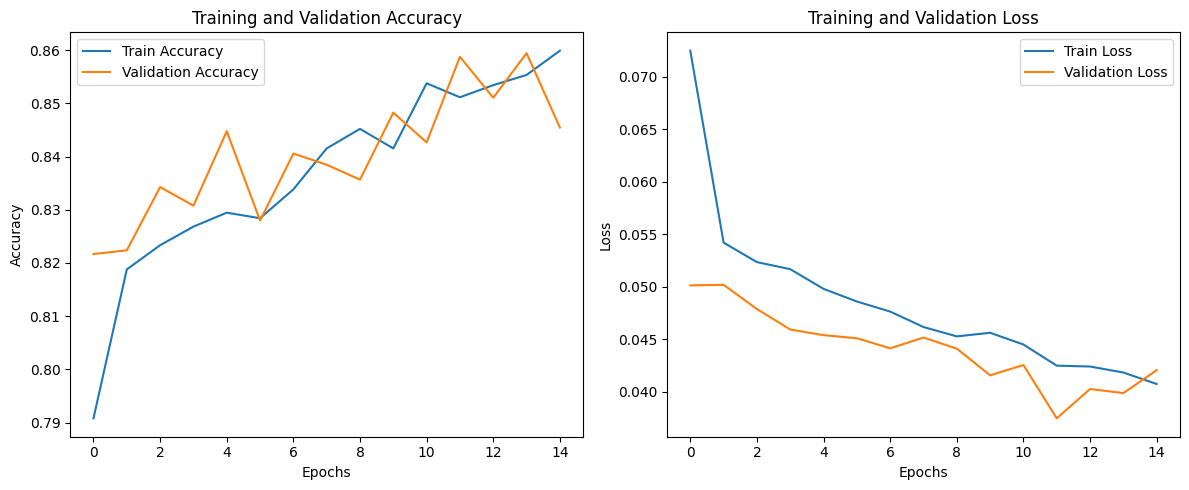

In [36]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## Block 9: Make Predictions on the Test Set and Prepare Submission

In [38]:
model.load_weights("best_model_savedmodel.keras")

In [39]:
# Loading the full test dataset is not probably the best approach

# Load and predict on the test set
test_df = pd.read_csv(test_csv_path)
test_ids = test_df['ID'].values
X_test = np.array([load_and_normalize_npy_image(image_id, test_data_path) for image_id in test_ids])

# Predict probabilities and classify a!s 0 or 1
y_test_pred = (model.predict(X_test) > 0.5).astype(int) # the output is a probability that goes from 0 to 1.
                                                        # Here we use 0.5 as the threshold

# Count the number of predictions for each class
unique, counts = np.unique(y_test_pred, return_counts=True)
prediction_counts = dict(zip(unique, counts))
print("Prediction counts:", prediction_counts)

# Prepare submission file
submission_df = pd.DataFrame({
    'ID': test_ids,
    'label': y_test_pred.flatten()  # Flatten to match submission format
})
submission_df.to_csv('Submission_Filejj.csv', index=False)
print("Sample submission file created as 'Submission_Filen.csv'.")

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Prediction counts: {np.int64(0): np.int64(5119), np.int64(1): np.int64(279)}
Sample submission file created as 'Submission_Filen.csv'.
